In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
houses = pd.read_csv('Casas_venezuela.csv')
apartments = pd.read_csv('Departamentos_venezuela.csv')

In [3]:
def graph_categorical_relations(df, features, showfliers=True):
    for col in features:
        fig = plt.figure(figsize=(19,6))
        ax = fig.gca()

        if df[col].dtype == "object":
            grouped = df.groupby(col)
            df2 = pd.DataFrame({col:vals['Precio'] for col,vals in grouped})
            medians = df2.median()
            medians.sort_values(ascending=True, inplace=True)
            df2 = df2[medians.index]
            df2.boxplot(ax=ax, showfliers=showfliers)

            labels = [label.get_text() + f" (n: {df2[label.get_text()].count()})" for label in ax.get_xticklabels()]
        else:
            df.boxplot(column = 'Precio', by = col, ax=ax, showfliers=showfliers)
            
            if df[col].dtype == 'int64':
                labels = [label.get_text() + f" (n: {df.loc[df[col]==int(label.get_text()), col].size})" for label in ax.get_xticklabels()]
            elif df[col].dtype == 'float64':
                labels = [label.get_text() + f" (n: {df.loc[df[col]==float(label.get_text()), col].size})" for label in ax.get_xticklabels()]

        ax.set_ylabel('Precio')
        ax.get_yaxis().set_major_formatter(lambda x, pos: f'{x:.0f}')

        if len(ax.get_xticklabels()) > 10 and any([len(str(label.get_text())) >= 5 for label in ax.get_xticklabels()]):
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        elif len(ax.get_xticklabels()) > 5 and any([len(str(label.get_text())) >= 5 for label in ax.get_xticklabels()]):
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
        
        ax.set_xticklabels(labels)

        ax.set_title('Precio en función de ' + col)
    plt.show()

In [4]:
from scipy.stats import linregress

In [12]:
def graph_numeric_relations(df, features):
    for col in features:
        fig = plt.figure(figsize=(9,6))
        ax = fig.gca()

        feature = df[col]

        try:
            feature = df[col].astype(int)
            label = df['Precio']
        except pd.errors.IntCastingNaNError:
            feature = df[ df[col].notnull() ][col]
            label = df[ df[col].notnull() ]['Precio']

        corr = feature.corr(label)

        plt.scatter(x=feature, y=label)

        lin_reg = linregress(x=feature, y=label)
        line = [ lin_reg.slope * xi + lin_reg.intercept for xi in feature ]
        ax.plot(feature, line, color='red')

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, f'Correlación: {corr}\n'+r'$R^{2}$'+f': {lin_reg.rvalue**2:.4f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)

        ax.set_xlabel(col)
        ax.set_ylabel('Precio')
        ax.ticklabel_format(style='plain')
        ax.set_title(f'Precio en función de {col}')
    plt.show()

# Objetivos

La idea es predecir el precio de los inmuebles utilizando modelos de machine learning.

## Casas

In [6]:
houses.head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Terreno,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Medios Baños,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,Calle,País,Estado,Ciudad,Urbanización
0,150000,VE 23-26807,Casa,Duplex,225,225,Usado,4,5,4,1.0,Cubierto,2.0,No,Si,Publica,Venezuela,Distrito Metropolitano,Caracas,La Boyera
1,50000,VE 23-26803,Casa,1 Nivel,178,178,Usado,6,5,5,0.0,Ninguno,NaN,No,No,Publica,Venezuela,Distrito Metropolitano,Caracas,La Pastora
2,150000,VE 23-26802,Casa,1 Nivel,630,630,Usado,5,5,4,1.0,Descubierto,2.0,Si,No,Cerrada con Vigilancia,Venezuela,Portuguesa,Araure,Araguaney
3,78000,VE 23-26799,Casa,Duplex,320,200,Usado,4,4,3,1.0,Cubierto,3.0,Parcialmente,Si,Cerrada con Vigilancia,Venezuela,Portuguesa,Araure,Maria Gabriela
4,120000,VE 23-26796,Casa,Duplex,212,178,Usado,3,3,2,1.0,Cubierto,3.0,Si,Si,Cerrada con Vigilancia,Venezuela,Portuguesa,Araure,Las Mesetas de Araure


In [7]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4316 entries, 0 to 4315
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Precio                      4316 non-null   int64  
 1   Codígo RAH                  4316 non-null   object 
 2   Tipo de Propiedad           4316 non-null   object 
 3   Estilo                      4316 non-null   object 
 4   Área Privada                4316 non-null   int64  
 5   Terreno                     4316 non-null   int64  
 6   Estado Del Inmueble         4316 non-null   object 
 7   Dormitorios                 4316 non-null   int64  
 8   Total Baños                 4316 non-null   int64  
 9   Baños Completos             4316 non-null   int64  
 10  Medios Baños                4316 non-null   float64
 11  Tipo De Estacionamiento     4316 non-null   object 
 12  Puestos De Estacionamiento  3778 non-null   float64
 13  Amoblado                    4316 

Voy a definir las features (variables) que en principio parecen interesantes para el modelo.

In [8]:
house_numeric_features = ['Área Privada', 'Terreno']
houses_ordinal_features = ['Dormitorios', 'Total Baños', 'Baños Completos', 'Medios Baños', 'Puestos De Estacionamiento']
houses_categorical_features = ['Estilo', 'Estado Del Inmueble','Tipo De Estacionamiento', 'Amoblado' ,'Calle', 'Dormitorio De Servicio', 'Ciudad', 'Estado', 'Urbanización']

In [9]:
# Filtrado de outliers
houses = houses[ houses[house_numeric_features + houses_ordinal_features].apply(lambda x: ((x - x.median()) / (x.quantile(q=0.75)-x.quantile(q=0.25))) < 1.5 ).all(axis=1) ]

houses.head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Terreno,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Medios Baños,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,Calle,País,Estado,Ciudad,Urbanización
0,150000,VE 23-26807,Casa,Duplex,225,225,Usado,4,5,4,1.0,Cubierto,2.0,No,Si,Publica,Venezuela,Distrito Metropolitano,Caracas,La Boyera
2,150000,VE 23-26802,Casa,1 Nivel,630,630,Usado,5,5,4,1.0,Descubierto,2.0,Si,No,Cerrada con Vigilancia,Venezuela,Portuguesa,Araure,Araguaney
3,78000,VE 23-26799,Casa,Duplex,320,200,Usado,4,4,3,1.0,Cubierto,3.0,Parcialmente,Si,Cerrada con Vigilancia,Venezuela,Portuguesa,Araure,Maria Gabriela
4,120000,VE 23-26796,Casa,Duplex,212,178,Usado,3,3,2,1.0,Cubierto,3.0,Si,Si,Cerrada con Vigilancia,Venezuela,Portuguesa,Araure,Las Mesetas de Araure
5,30000,VE 23-26791,Casa,Multipes Niveles,215,215,Usado,3,3,3,0.0,Cubierto,2.0,No,No,Cerrada con Vigilancia,Venezuela,Lara,Cabudare,Santa Cecilia


In [10]:
houses.shape

(2555, 20)

### Observaciones gráficas

Ahora voy a graficar su comportamiento con el precio para ver si realmente son utiles o no.

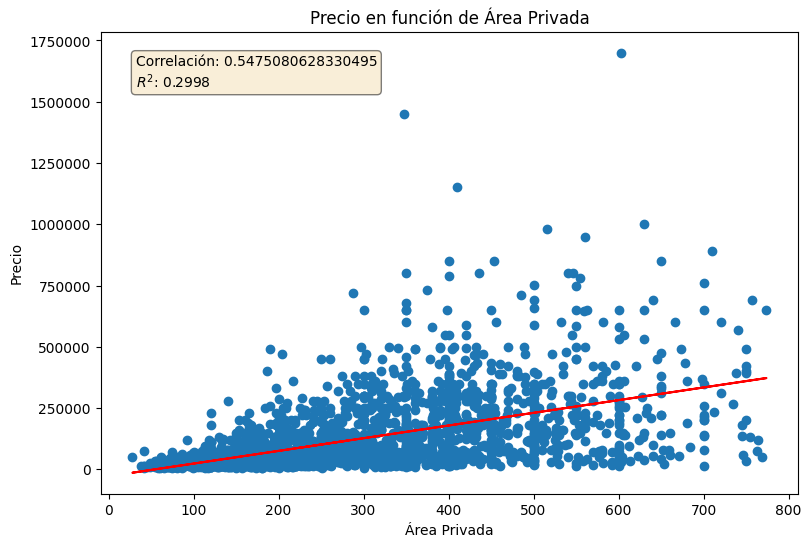

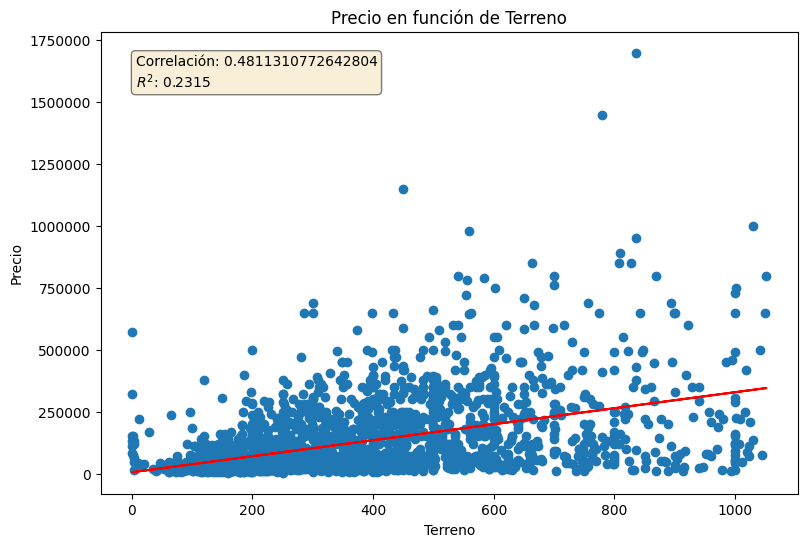

In [13]:
graph_numeric_relations(houses, house_numeric_features)

Se observa como en general el precio de las casas crece cuando crece su área y terreno.

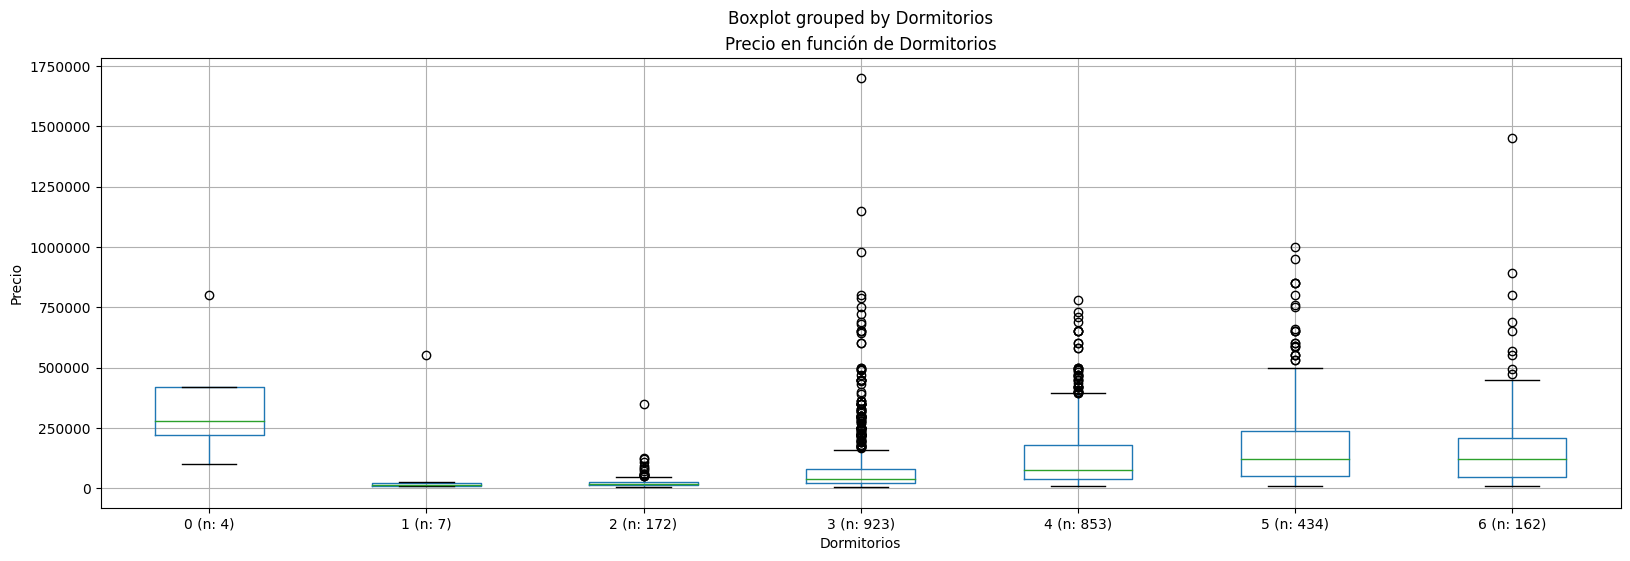

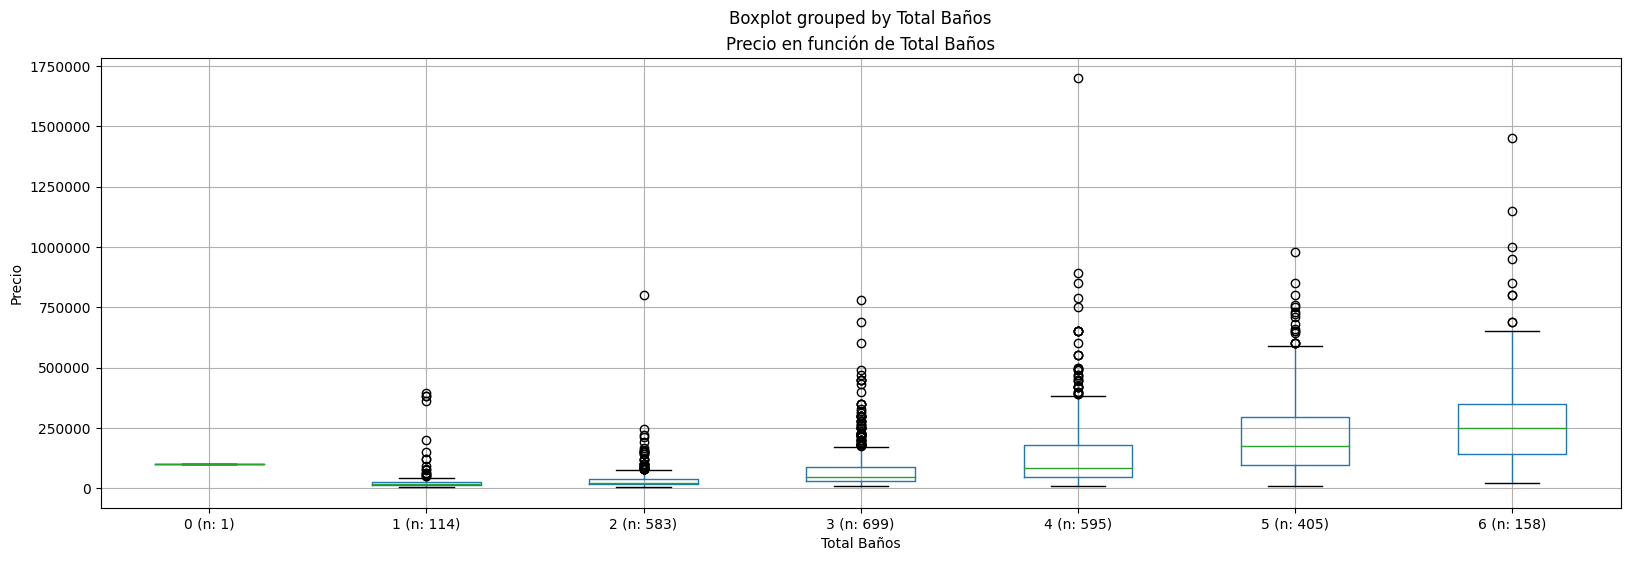

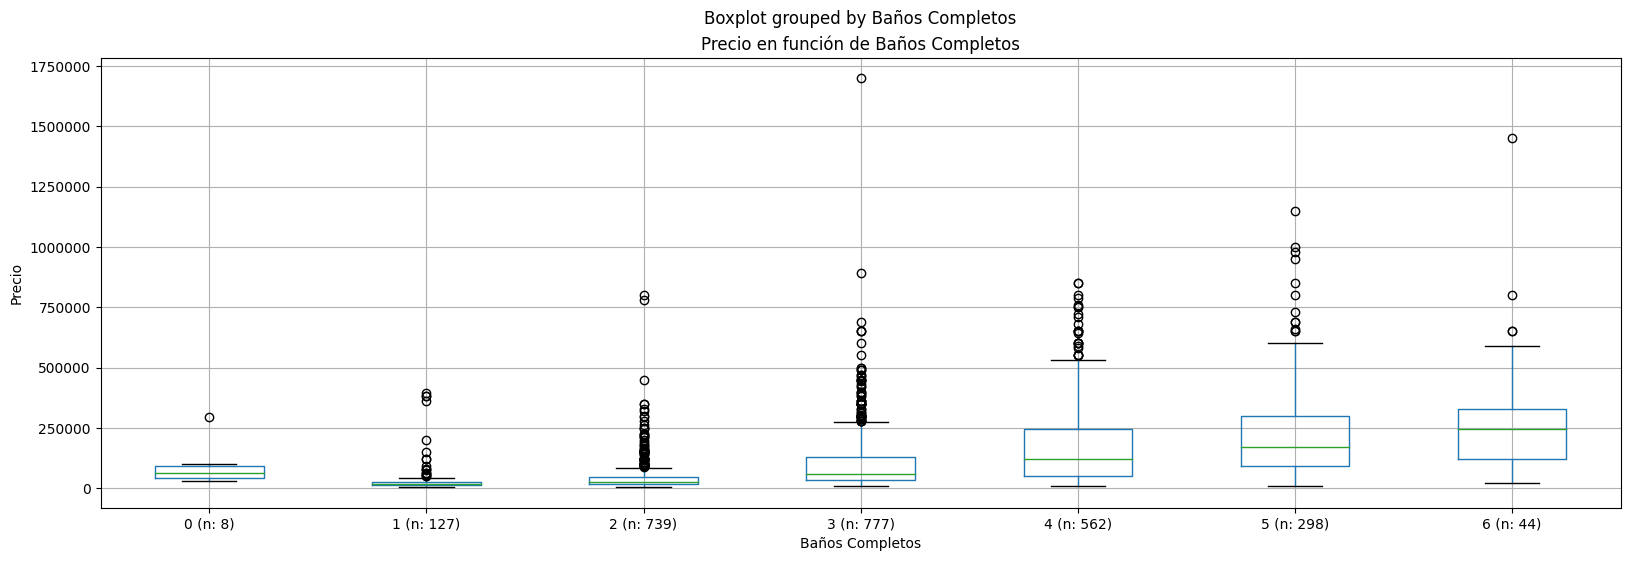

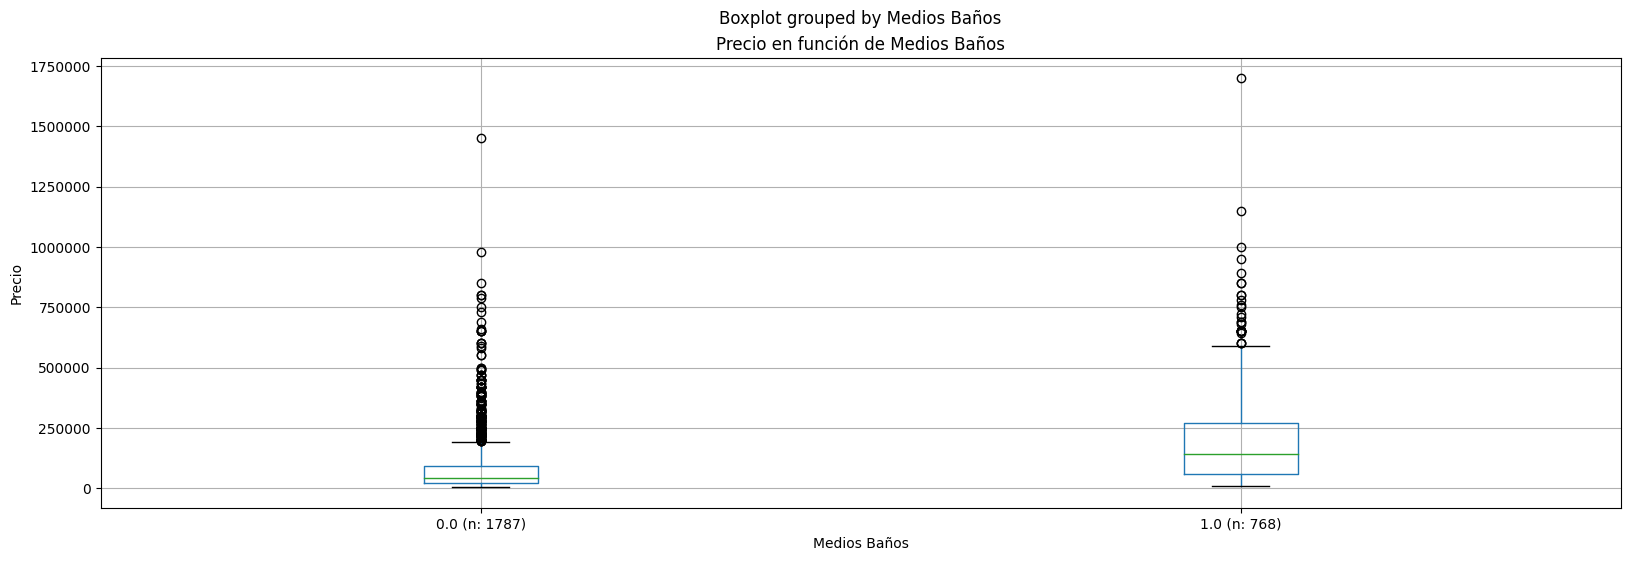

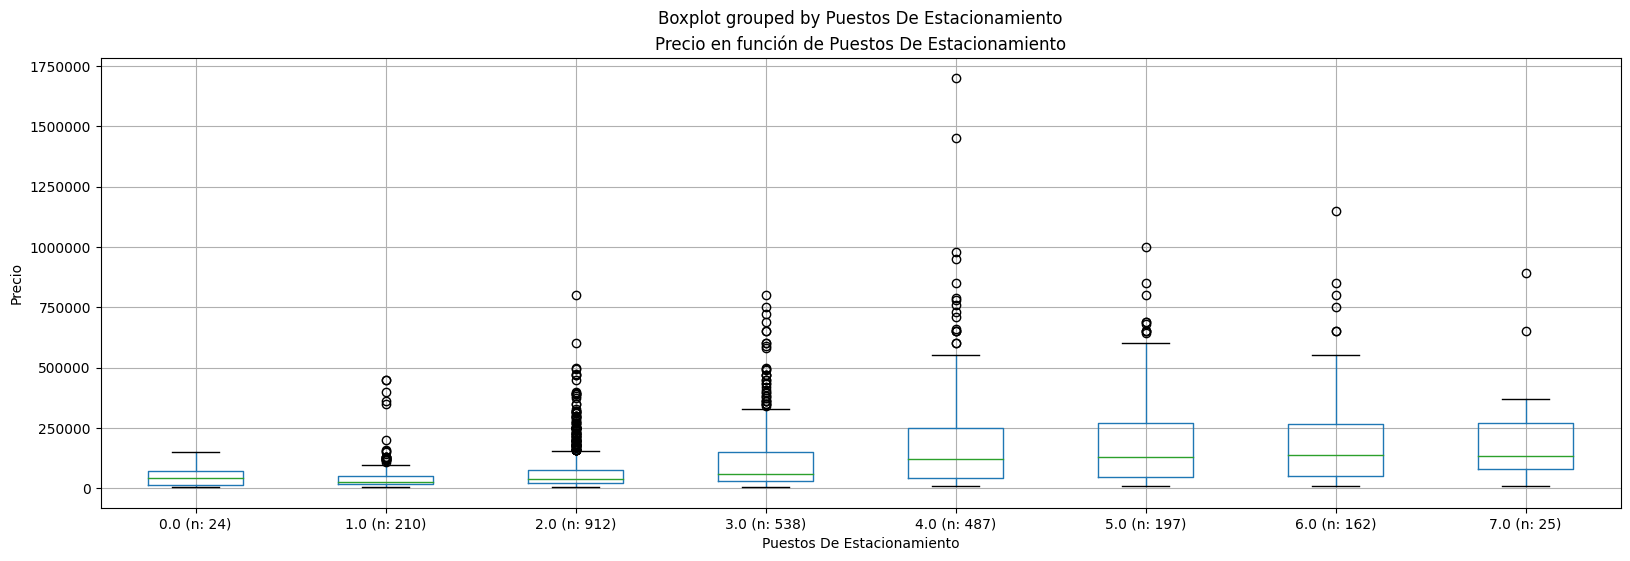

In [14]:
graph_categorical_relations(houses, houses_ordinal_features)

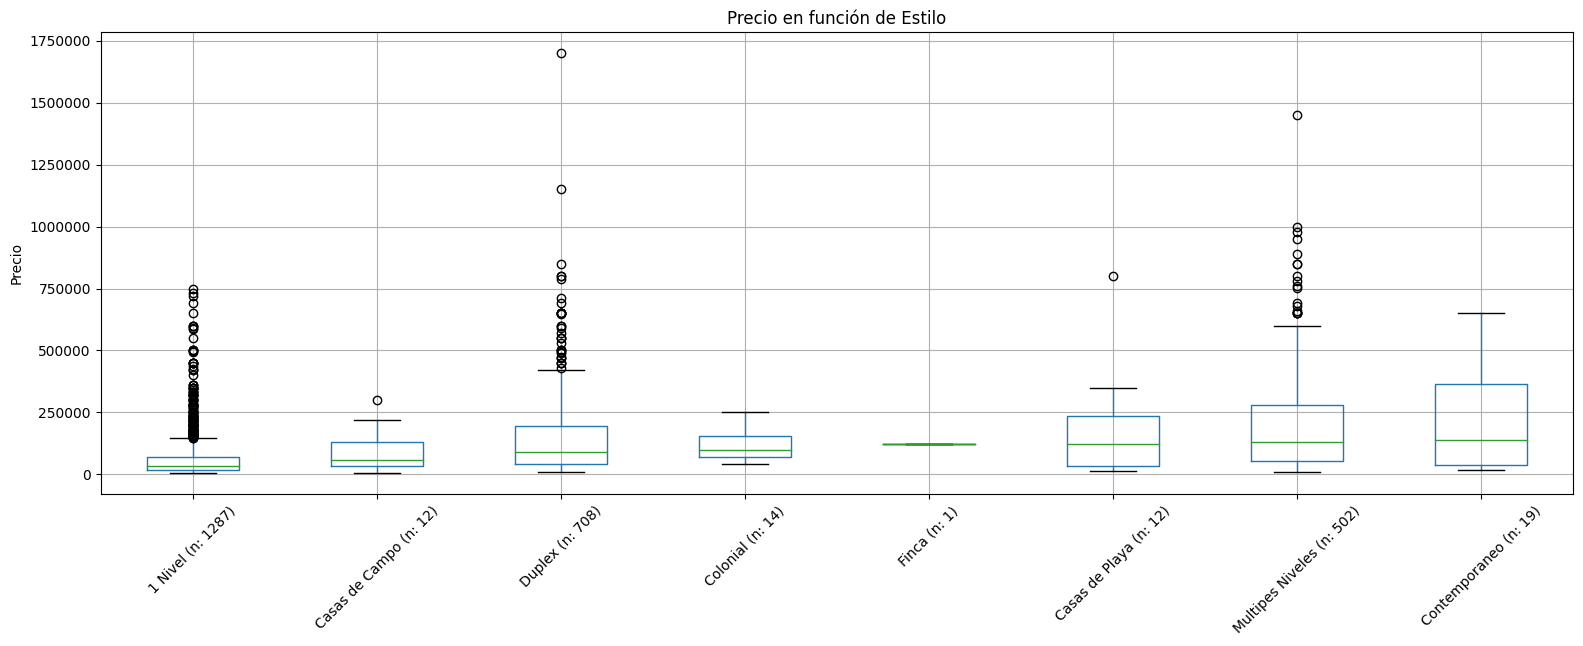

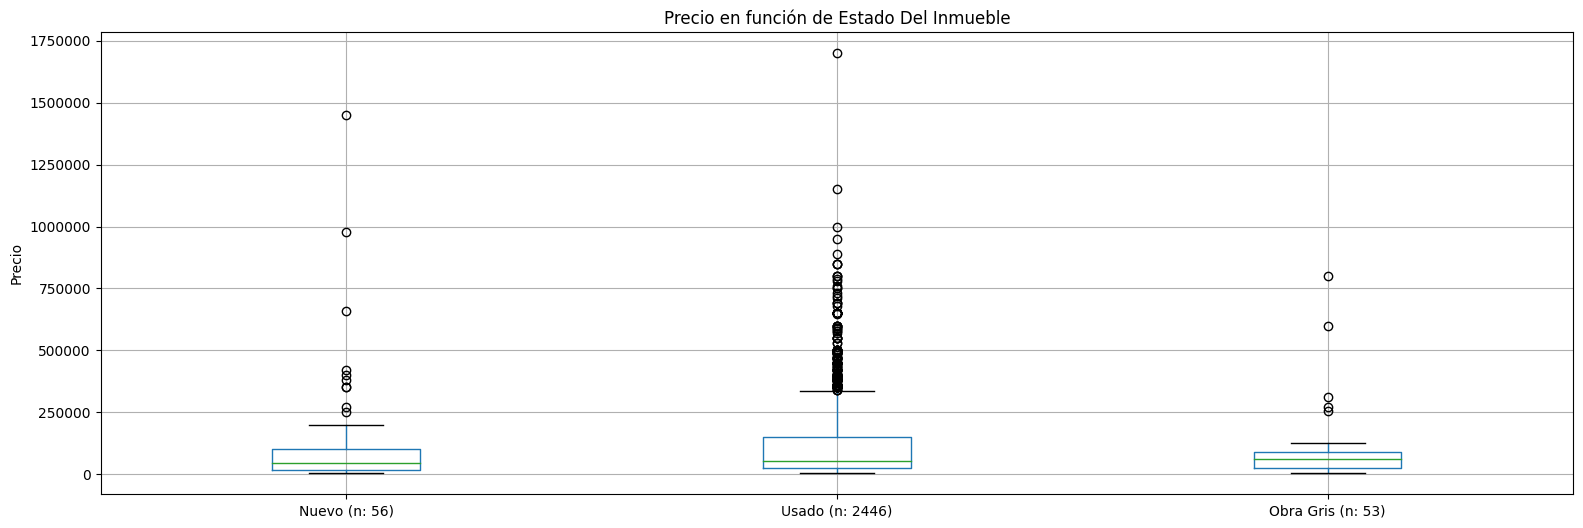

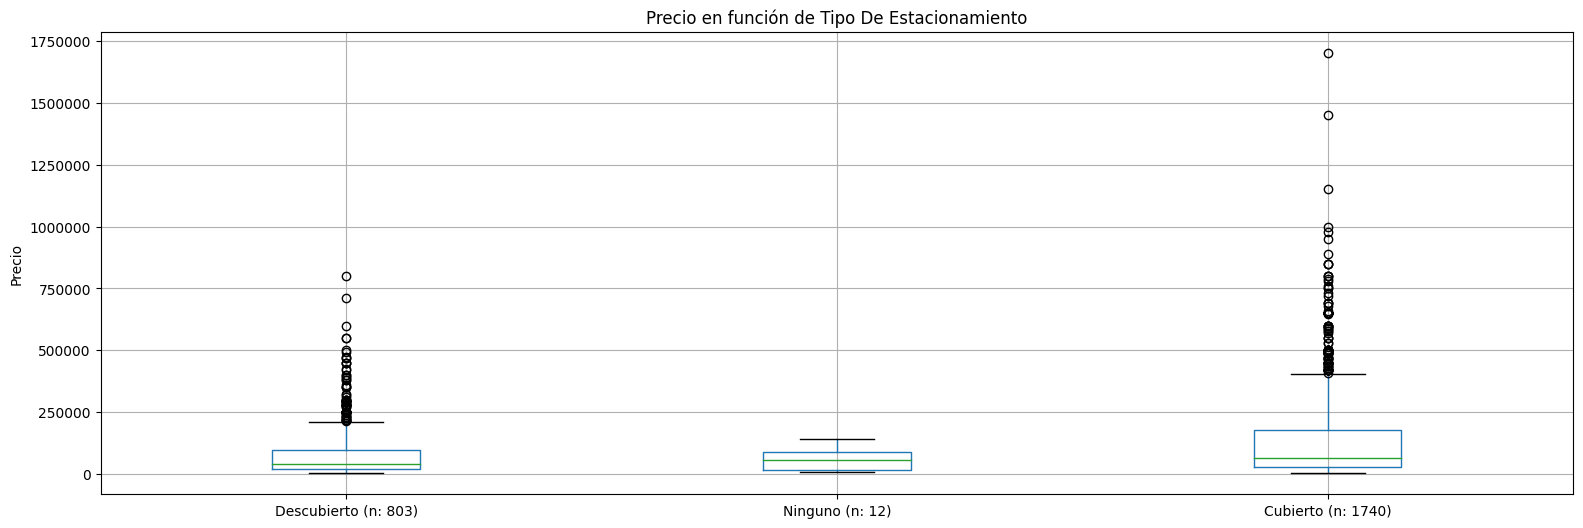

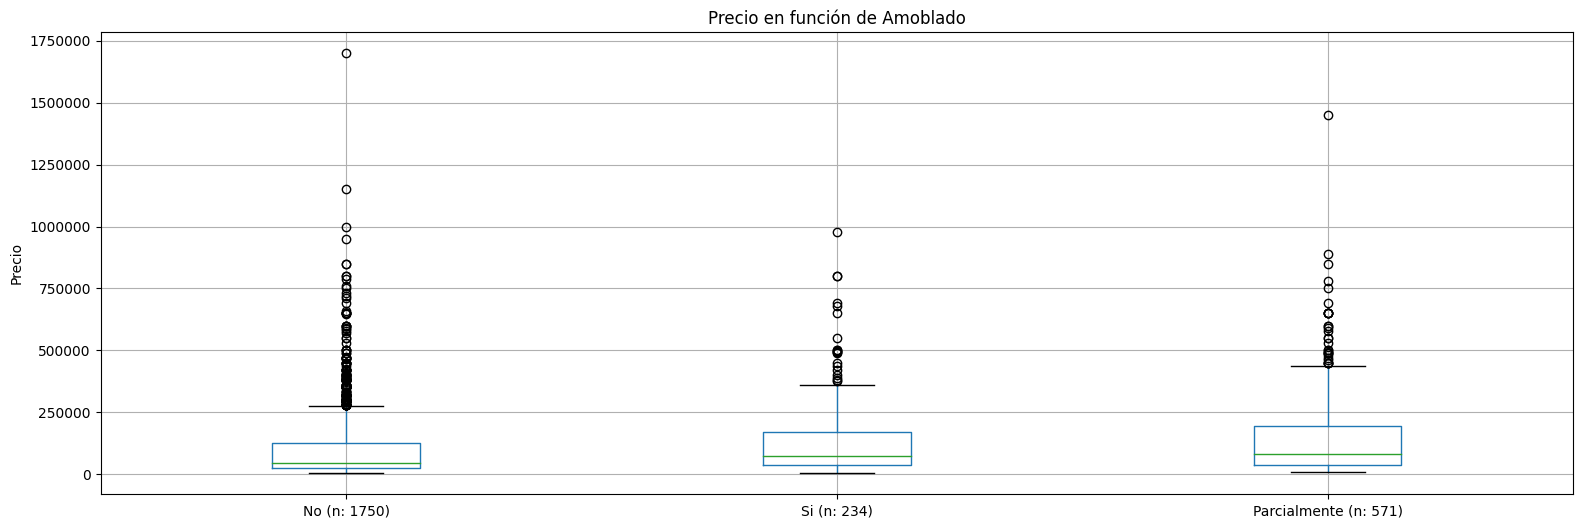

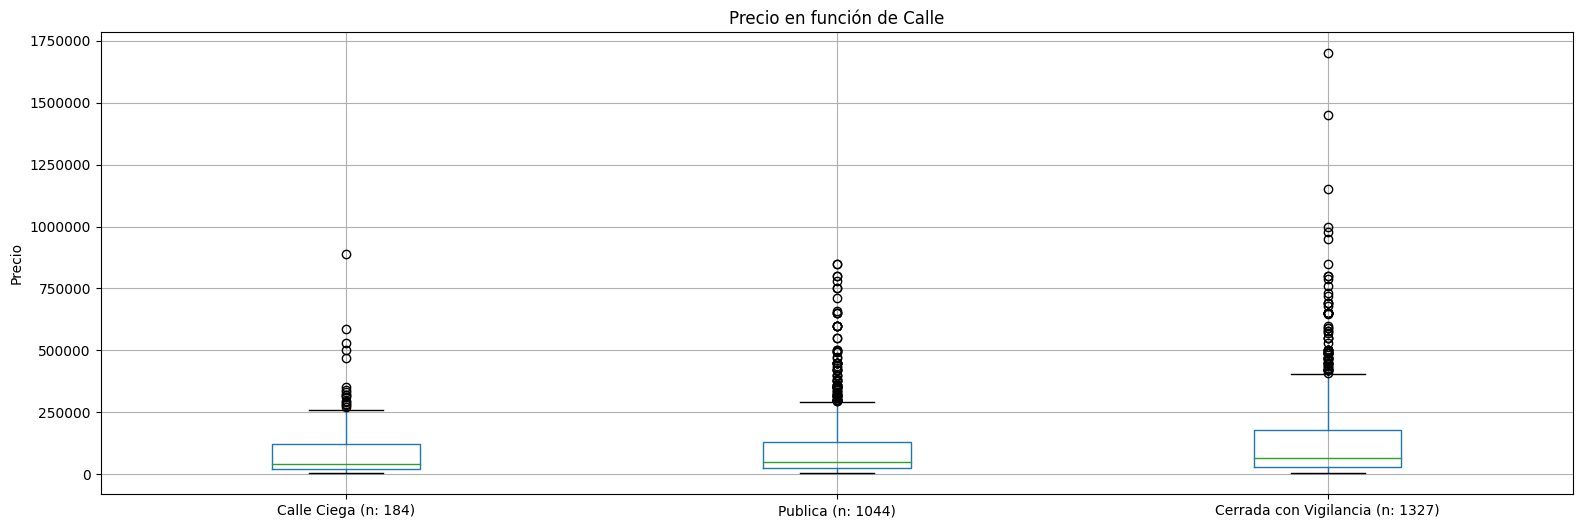

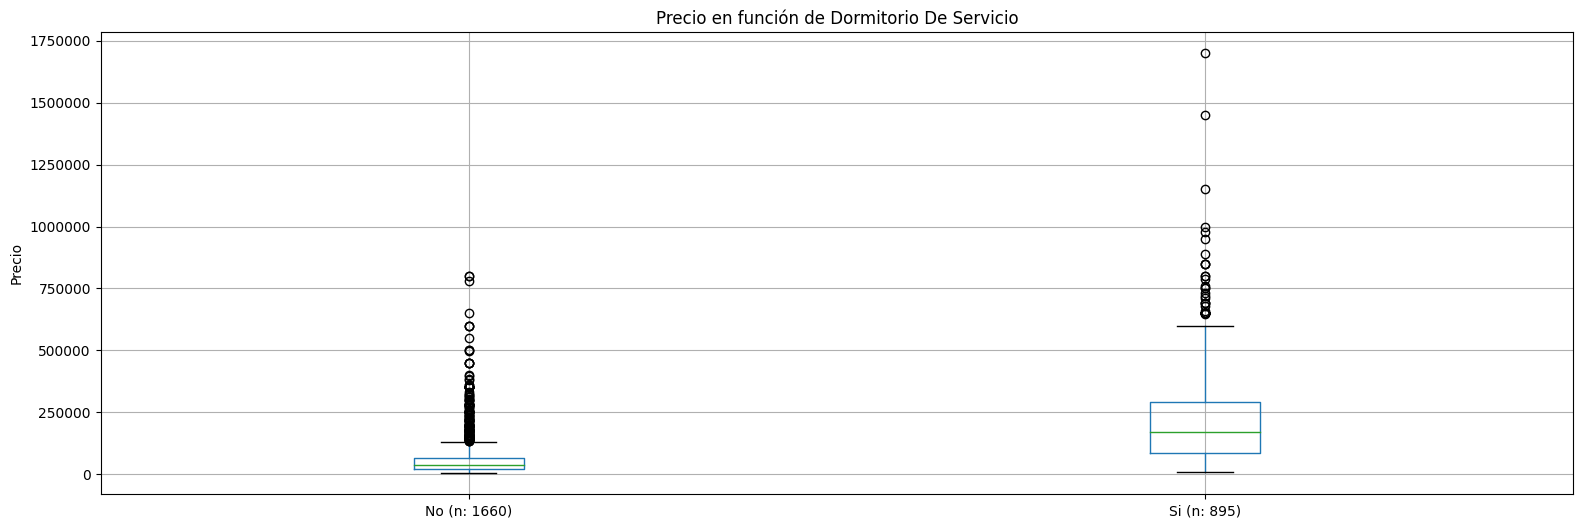

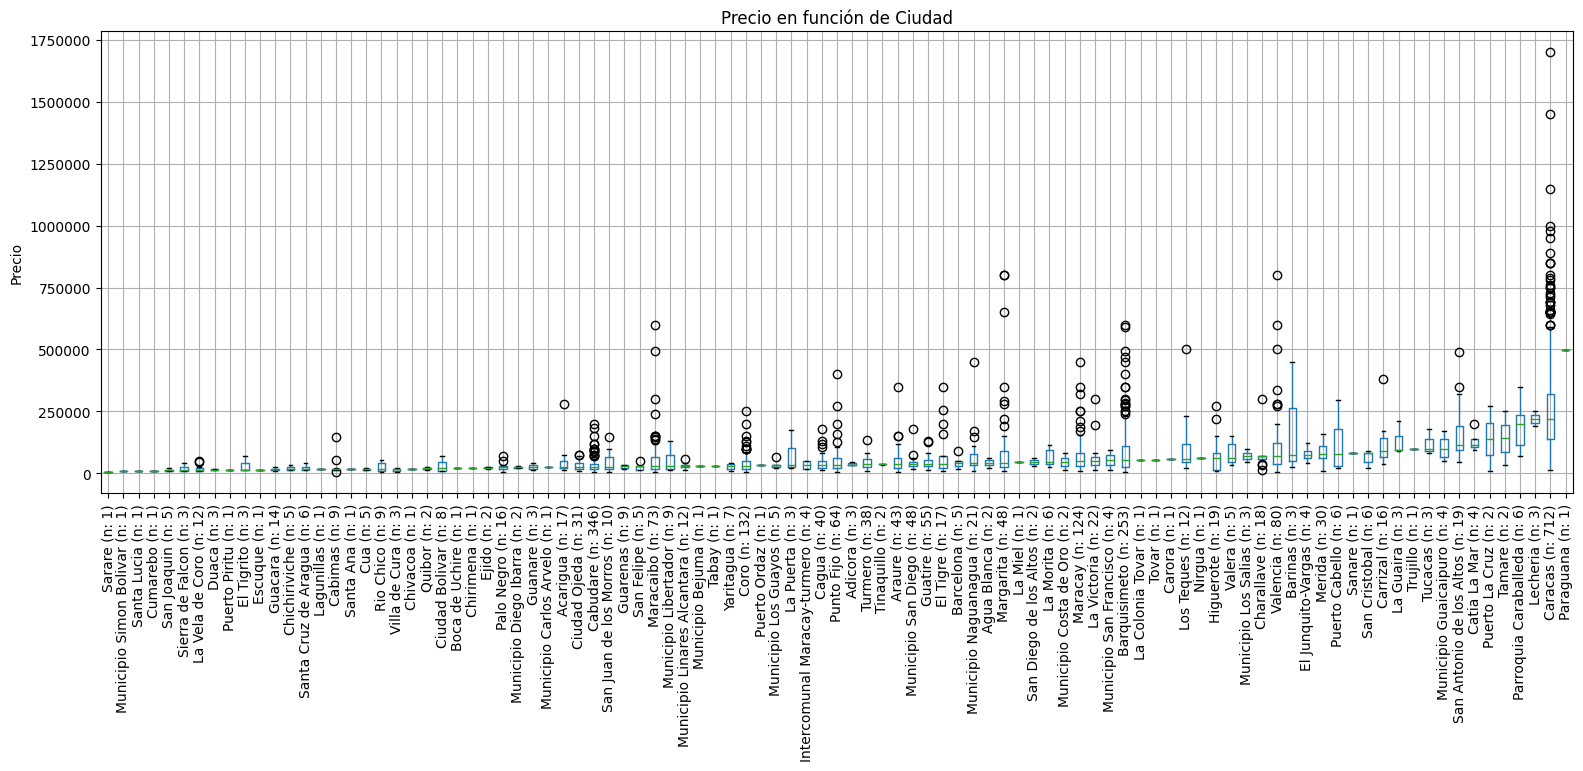

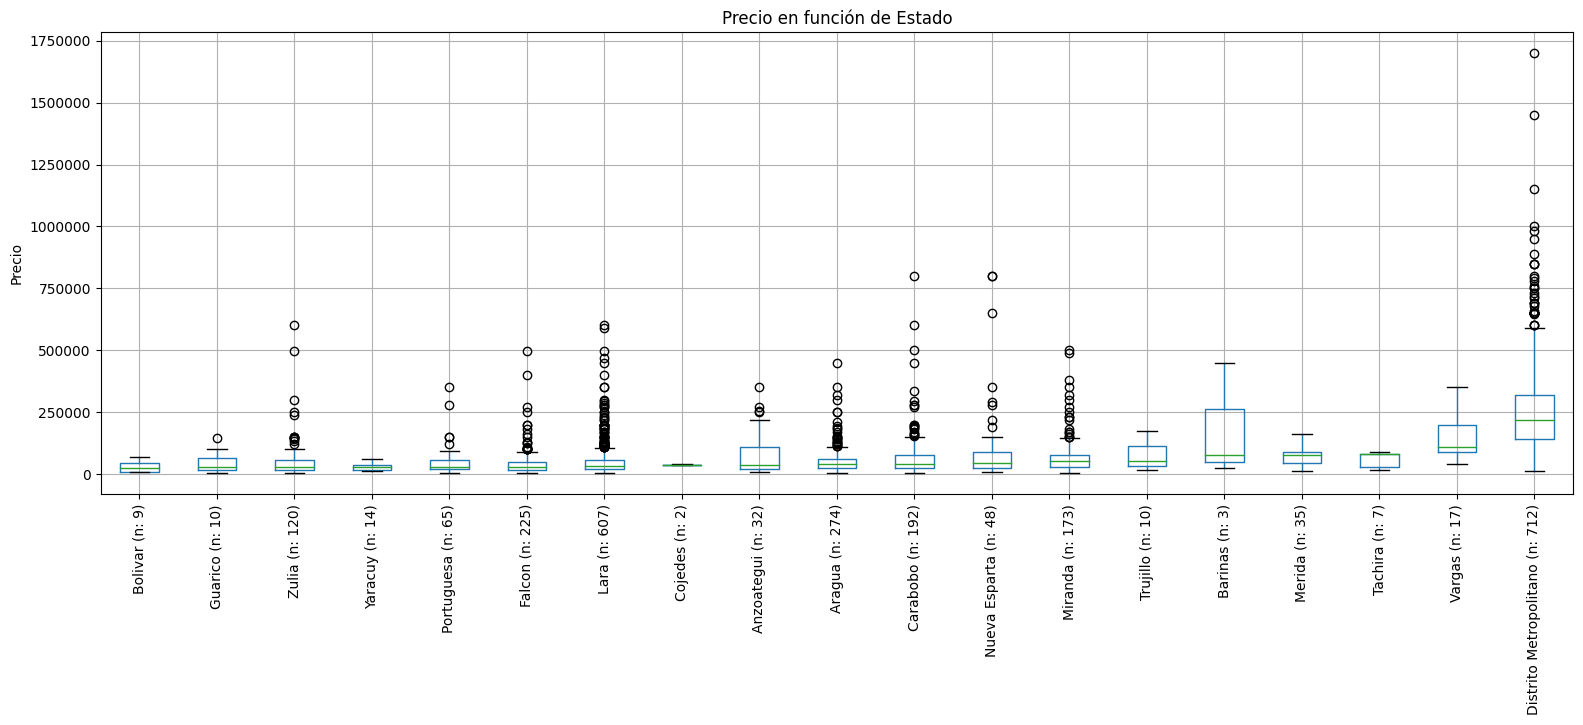

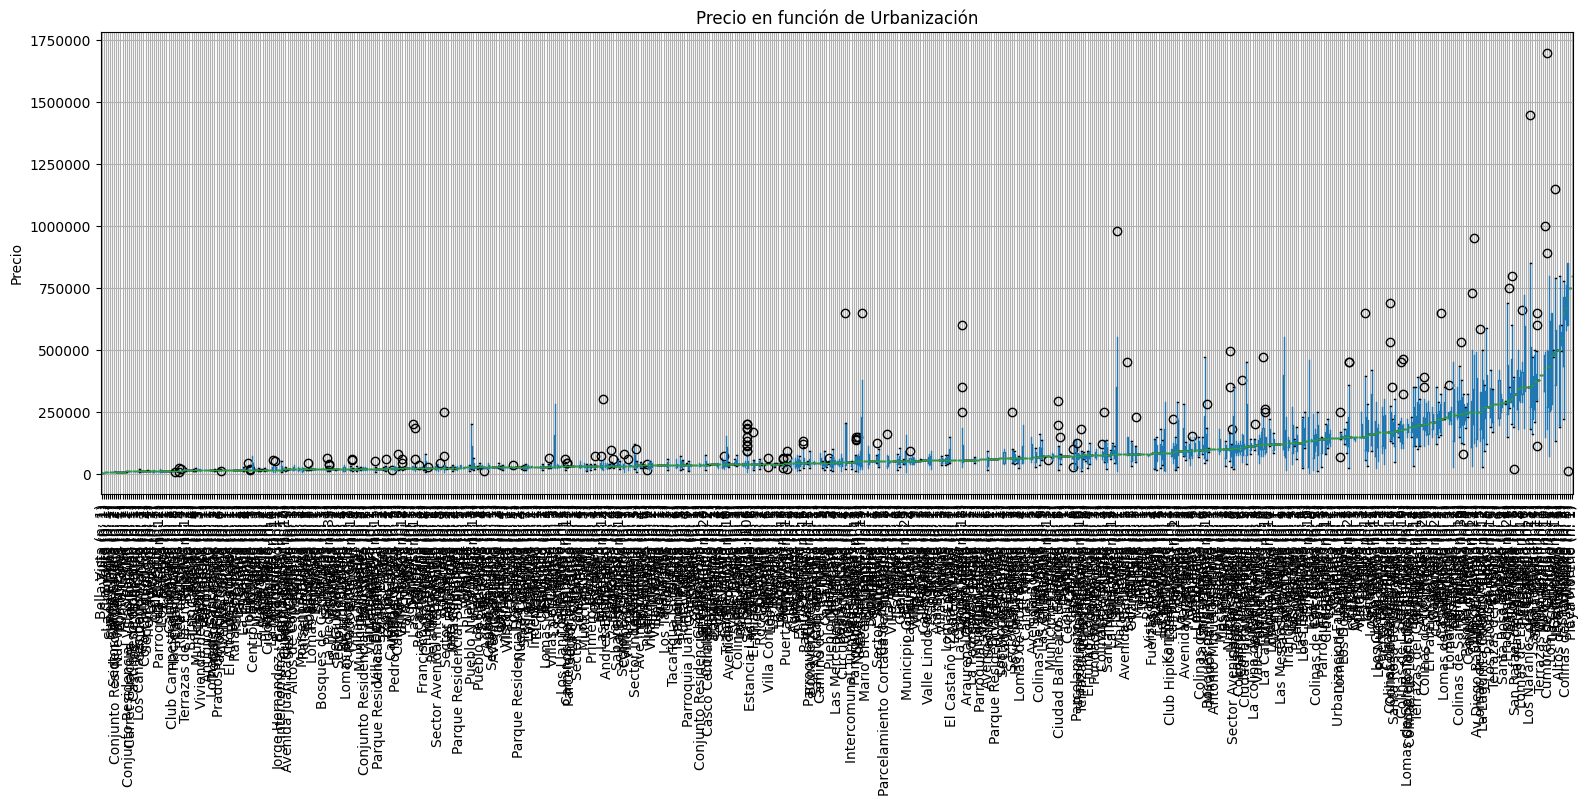

In [15]:
graph_categorical_relations(houses, houses_categorical_features)

Con estos gráficos puede verse la incidencia que las variables tienen en el precio.  
Cabe destacar que si bien la urbanización (barrio) de la casa afecta al precio, se lo va a dejar de lado porque hay muchas ciudades (>700), y si se las incluyera en el modelo se necesitaría una columna por cada una. Este gran número de columnas comparado con el número de filas tendería a provocar overfitting.

In [16]:
houses_categorical_features = [cat for cat in houses_categorical_features if cat != 'Urbanización']

Se puede observar como el precio de la casa aumenta con el terreno y área de la misma. Pero el área de la casa, así como todas las variables ordinales, es generalmente linealmente dependiente con el terreno de la misma.

In [17]:
def graph_area_relation(df, features):
    for col in features:
        fig = plt.figure(figsize=(5,5))
        ax = plt.gca()
        plt.scatter(houses['Área Privada'], houses[col])
        ax.set_xlabel('Área Privada')
        ax.set_ylabel(col)
        ax.set_title(col + ' en función del área')
        trend = np.polyfit(houses.loc[houses[col].notnull(), 'Área Privada'], houses.loc[houses[col].notnull(), col], 1)
        p = np.poly1d(trend)
        plt.plot(houses['Área Privada'], p(houses['Área Privada']), color='red')
    plt.show()

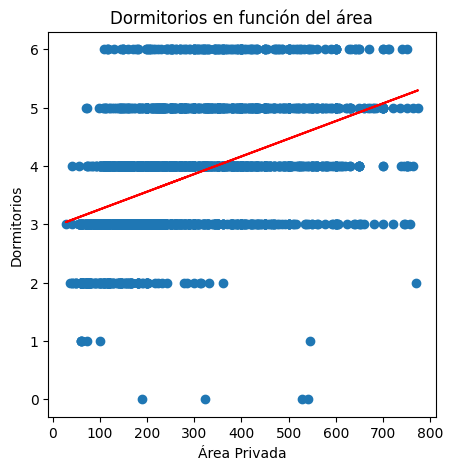

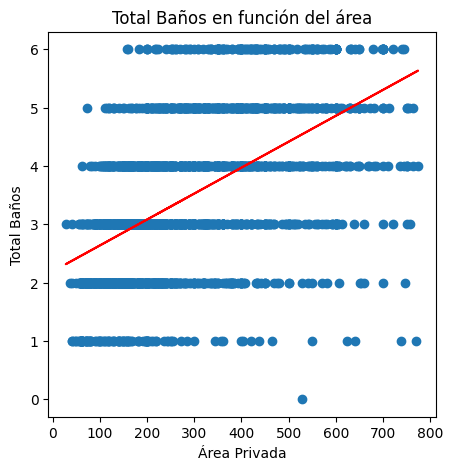

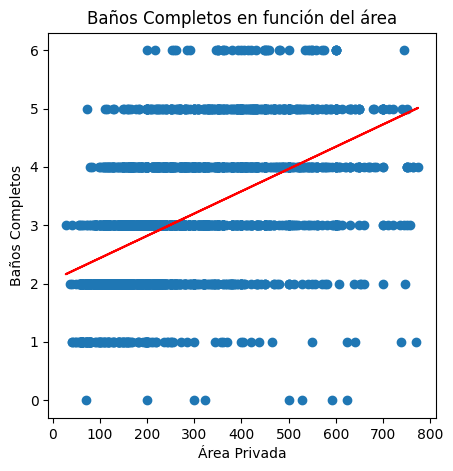

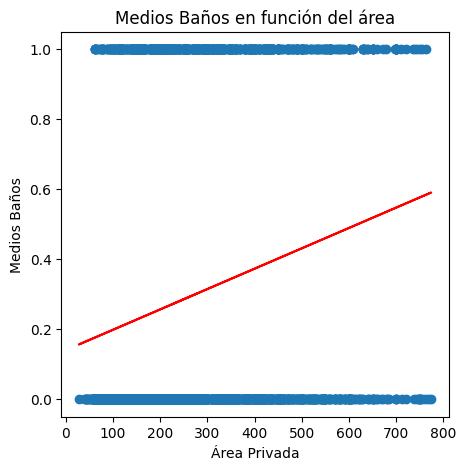

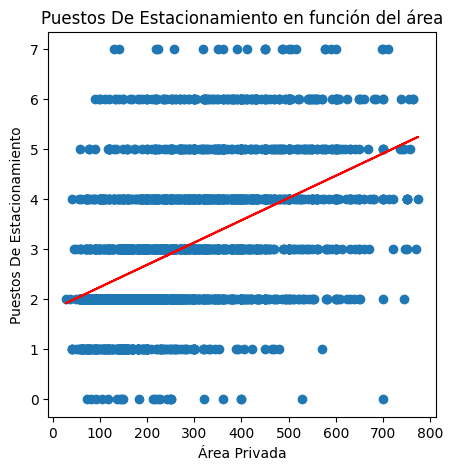

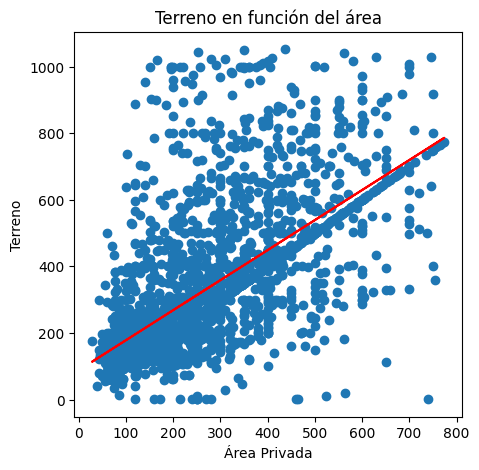

In [18]:
graph_area_relation(houses, houses_ordinal_features + ['Terreno'])

### Preprocesamiento

Primero quiero revisar si me quedaron columnas con valores nulos.

In [19]:
houses.isnull().sum()

Precio                        0
Codígo RAH                    0
Tipo de Propiedad             0
Estilo                        0
Área Privada                  0
Terreno                       0
Estado Del Inmueble           0
Dormitorios                   0
Total Baños                   0
Baños Completos               0
Medios Baños                  0
Tipo De Estacionamiento       0
Puestos De Estacionamiento    0
Amoblado                      0
Dormitorio De Servicio        0
Calle                         0
País                          0
Estado                        0
Ciudad                        0
Urbanización                  0
dtype: int64

En scrapeos anteriores habia discrepancias entre los puestos de estacionamiento y tipo de estacionamiento, asi que los voy a revisar.

In [20]:
houses[(houses['Puestos De Estacionamiento'] != 0) & (houses['Tipo De Estacionamiento'] == "Ninguno")].head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Terreno,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Medios Baños,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,Calle,País,Estado,Ciudad,Urbanización


In [21]:
houses[(houses['Puestos De Estacionamiento'] == 0) & (houses['Tipo De Estacionamiento'] != "Ninguno")].head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Terreno,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Medios Baños,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,Calle,País,Estado,Ciudad,Urbanización
34,55000,VE 23-26639,Casa,1 Nivel,250,250,Usado,4,4,4,0.0,Cubierto,0.0,No,No,Publica,Venezuela,Distrito Metropolitano,Caracas,San Martin
1177,25000,VE 23-21354,Casa,1 Nivel,250,320,Usado,6,2,2,0.0,Cubierto,0.0,No,No,Publica,Venezuela,Guarico,San Juan de los Morros,Avenida Miranda
1300,18000,VE 23-20613,Casa,1 Nivel,148,148,Usado,5,1,1,0.0,Cubierto,0.0,No,No,Publica,Venezuela,Carabobo,Valencia,San Blas
1318,47999,VE 23-20477,Casa,Multipes Niveles,321,321,Usado,4,2,2,0.0,Cubierto,0.0,No,No,Publica,Venezuela,Distrito Metropolitano,Caracas,Catia
1574,14000,VE 23-19008,Casa,1 Nivel,213,213,Usado,6,1,1,0.0,Cubierto,0.0,No,No,Publica,Venezuela,Falcon,Coro,Centro


In [22]:
mask_no_parking_spots = (houses['Puestos De Estacionamiento'] == 0) & (houses['Tipo De Estacionamiento'] != "Ninguno")
houses.loc[mask_no_parking_spots, 'Tipo De Estacionamiento'] = 'Ninguno'  

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [24]:
# Estandarizacion de columnas numericas
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encoding para columnas categoricas
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combinando preprocesadores
preprocessor = ColumnTransformer(transformers=
                                 [('num', numeric_transformer, house_numeric_features),('cat', categorical_transformer, houses_categorical_features)])

### Entrenamiento

In [25]:
print(house_numeric_features, houses_ordinal_features, houses_categorical_features, sep='\n')

['Área Privada', 'Terreno']
['Dormitorios', 'Total Baños', 'Baños Completos', 'Medios Baños', 'Puestos De Estacionamiento']
['Estilo', 'Estado Del Inmueble', 'Tipo De Estacionamiento', 'Amoblado', 'Calle', 'Dormitorio De Servicio', 'Ciudad', 'Estado']


In [26]:
# Me quedo solo con las columnas que voy a usar
houses = houses[house_numeric_features + houses_ordinal_features + houses_categorical_features + ['Precio']]

In [27]:
# Separo en datasets de features y label
x_houses, y_houses = houses.drop(labels=['Precio'], axis=1), houses['Precio']
print('Features:',x_houses[:3], '\nLabel:',y_houses[:3].values, sep='\n')

Features:
   Área Privada  Terreno  Dormitorios  Total Baños  Baños Completos  \
0           225      225            4            5                4   
2           630      630            5            5                4   
3           320      200            4            4                3   

   Medios Baños  Puestos De Estacionamiento   Estilo Estado Del Inmueble  \
0           1.0                         2.0   Duplex               Usado   
2           1.0                         2.0  1 Nivel               Usado   
3           1.0                         3.0   Duplex               Usado   

  Tipo De Estacionamiento      Amoblado                   Calle  \
0                Cubierto            No                 Publica   
2             Descubierto            Si  Cerrada con Vigilancia   
3                Cubierto  Parcialmente  Cerrada con Vigilancia   

  Dormitorio De Servicio   Ciudad                  Estado  
0                     Si  Caracas  Distrito Metropolitano  
2          

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# Separo en dataframes de entrenamiento y verificacion
x_houses_train, x_houses_test, y_houses_train, y_houses_test = train_test_split(x_houses, y_houses, test_size=0.2, random_state=69)
print(f"Training set: {x_houses_train.shape[0]} filas\nTest set: {x_houses_test.shape[0]} filas")

Training set: 2044 filas
Test set: 511 filas


In [30]:
preprocessor.fit(x_houses_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Área Privada', 'Terreno']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Estilo', 'Estado Del Inmueble',
                                  'Tipo De Estacionamiento', 'Amoblado',
                                  'Calle', 'Dormitorio De Servicio', 'Ciudad',
                                  'Estado'])])

In [31]:
x_houses_train_ = preprocessor.transform(x_houses_train)
x_houses_test_ = preprocessor.transform(x_houses_test)

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
model = LinearRegression().fit(x_houses_train_, y_houses_train)

In [34]:
houses_predictions = model.predict(x_houses_test_)

In [35]:
print('Labels predichas: ', np.round(houses_predictions[:5]))
print('Labels reales: ', y_houses_test[:5].values)

Labels predichas:  [ 73091. -50785. 144487.  37812. 202237.]
Labels reales:  [ 21000   5000  70000  16000 450000]


In [36]:
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
mse = mean_squared_error(y_houses_test, houses_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_houses_test, houses_predictions)
print("R2:", r2)

MSE: 9691909836.189137
RMSE: 98447.49786657422
R2: 0.5725208403781293


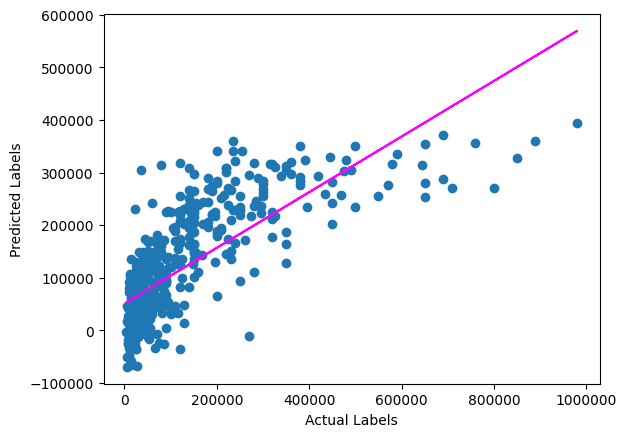

In [38]:
plt.scatter(y_houses_test, houses_predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
z = np.polyfit(y_houses_test, houses_predictions, 1)
p = np.poly1d(z)
plt.plot(y_houses_test,p(y_houses_test), color='magenta')
plt.gca().ticklabel_format(style='plain')
plt.show()

Voy a probar con otros modelos para comparar sus rendimientos.

In [39]:
from sklearn.linear_model import Lasso, ElasticNet

In [40]:
model = Lasso(max_iter=18000).fit(x_houses_train_, y_houses_train)

houses_predictions = model.predict(x_houses_test_)

mse = mean_squared_error(y_houses_test, houses_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_houses_test, houses_predictions)
print("R2:", r2)

MSE: 9686882235.825052
RMSE: 98421.96012996821
R2: 0.5727425917578758


In [41]:
model = ElasticNet().fit(x_houses_train_, y_houses_train)

houses_predictions = model.predict(x_houses_test_)

mse = mean_squared_error(y_houses_test, houses_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_houses_test, houses_predictions)
print("R2:", r2)

MSE: 11120139921.085262
RMSE: 105452.07404828632
R2: 0.5095261771221479


In [42]:
from sklearn.ensemble import RandomForestRegressor

In [43]:
model = RandomForestRegressor().fit(x_houses_train_, y_houses_train)

houses_predictions = model.predict(x_houses_test_)

mse = mean_squared_error(y_houses_test, houses_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_houses_test, houses_predictions)
print("R2:", r2)

MSE: 9447931922.043606
RMSE: 97200.47284886842
R2: 0.5832819262185892


In [44]:
from sklearn.ensemble import GradientBoostingRegressor

In [45]:
model = GradientBoostingRegressor().fit(x_houses_train_, y_houses_train)

houses_predictions = model.predict(x_houses_test_)

mse = mean_squared_error(y_houses_test, houses_predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_houses_test, houses_predictions)
print("R2:", r2)

MSE: 9720639458.74765
RMSE: 98593.30331593343
R2: 0.5712536685703904


Se puede ver como los resultados para todos los modelos son similares, lo que indica que el rendimiento no es tan dependiente del modelo utilizado, sino de los datos ingresados. Para este caso particular, seria conveniente tener aún más datos de casas y limpiarlos mas, lo cual es complicado porque muchas veces los datos fueron mal cargados en Rent-A-House y es dificil notarlo sin ir personalmente a la página para corroborarlo.

Solo para comprobar esta afirmación, quiero buscar parametros optimos para el mejor modelo.

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [47]:
params = {
    'n_estimators' : [10, 25, 50, 100, 200], 'max_features': [None, 5, 10, 20, 50],
    'min_samples_split': [2, 4, 8, 16], 'max_depth': [2, 4, 8, 16, 32, 50]}

score = make_scorer(r2_score)
gridsearch = GridSearchCV(RandomForestRegressor(), params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(x_houses_train_, y_houses_train)
print("Mejor combinacion de parametros:", gridsearch.best_params_, "\n")

model = gridsearch.best_estimator_
print(model, "\n")

predictions = model.predict(x_houses_test_)
mse = mean_squared_error(y_houses_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_houses_test, predictions)
print("R2:", r2)

Mejor combinacion de parametros: {'max_depth': 8, 'max_features': 20, 'min_samples_split': 8, 'n_estimators': 10} 

RandomForestRegressor(max_depth=8, max_features=20, min_samples_split=8,
                      n_estimators=10) 

MSE: 9601533839.918638
RMSE: 97987.41674275651
R2: 0.5765070366581901


A pesar de haber buscado parametros optimos para el modelo de Random Forests, no cambió mucho su rendimiento. Por esto concluyo que el problema no es el modelo utilizado ni su optimizacion, sino que se necesitaria mas datos de casas para compensar la baja calidad de los datos, y asi obtener mejores predicciones.  
De todas formas, voy a exportar el modelo.

In [48]:
import joblib

In [49]:
joblib.dump(model, './casas-modelo-ml.pkl')

['./casas-modelo-ml.pkl']

A pesar de no ser el mejor modelo del mundo, se podría usar para predecir el costo de las casas y asi buscar buenas ofertas.

In [50]:
houses['Precio predicho'] = np.round(model.predict(preprocessor.transform(houses.drop(labels=['Precio'], axis=1))))

houses.sort_values(['Precio', 'Precio predicho'], ascending=[True, False]).head()

,Área Privada,Terreno,Dormitorios,Total Baños,Baños Completos,Medios Baños,Puestos De Estacionamiento,Estilo,Estado Del Inmueble,Tipo De Estacionamiento,Amoblado,Calle,Dormitorio De Servicio,Ciudad,Estado,Precio,Precio predicho
2243,251,251,3,2,2,0.0,2.0,1 Nivel,Usado,Descubierto,No,Calle Ciega,No,Cabudare,Lara,3500,25923.0
2681,60,160,2,2,2,0.0,2.0,1 Nivel,Obra Gris,Descubierto,No,Publica,No,Villa de Cura,Aragua,4000,22279.0
2695,99,348,2,1,1,0.0,3.0,1 Nivel,Usado,Descubierto,No,Publica,No,Cabimas,Zulia,4500,27000.0
1666,300,368,3,2,2,0.0,1.0,1 Nivel,Usado,Descubierto,No,Publica,No,Maracaibo,Zulia,5000,50329.0
4146,180,180,2,2,2,0.0,2.0,1 Nivel,Nuevo,Descubierto,No,Calle Ciega,No,Araure,Portuguesa,5000,27434.0


## Departamentos

In [51]:
apartments.head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Medios Baños,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,País,Estado,Ciudad,Urbanización
0,265000,VE 23-26808,Apartamento,1 Nivel,292,Usado,5,6,5,1.0,Cubierto,4,No,Si,Venezuela,Miranda,Municipio Los Salias,Las Salias
1,75000,VE 23-26805,Apartamento,1 Nivel,100,Usado,3,2,2,0.0,Cubierto,1,No,No,Venezuela,Distrito Metropolitano,Caracas,El Marques
2,240000,VE 23-26804,Apartamento,Duplex,200,Usado,3,4,3,1.0,Cubierto,3,No,Si,Venezuela,Distrito Metropolitano,Caracas,Las Mercedes
3,75000,VE 23-26795,Apartamento,1 Nivel,153,Usado,4,2,2,0.0,Cubierto,2,No,Si,Venezuela,Distrito Metropolitano,Caracas,Manzanares
4,11500,VE 23-26790,Apartamento,1 Nivel,45,Usado,1,1,1,0.0,Descubierto,1,Parcialmente,No,Venezuela,Miranda,Rio Chico,Los Canales de Rio Chico


In [52]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Precio                      4320 non-null   int64  
 1   Codígo RAH                  4320 non-null   object 
 2   Tipo de Propiedad           4320 non-null   object 
 3   Estilo                      4320 non-null   object 
 4   Área Privada                4320 non-null   int64  
 5   Estado Del Inmueble         4320 non-null   object 
 6   Dormitorios                 4320 non-null   int64  
 7   Total Baños                 4320 non-null   int64  
 8   Baños Completos             4320 non-null   int64  
 9   Medios Baños                4320 non-null   float64
 10  Tipo De Estacionamiento     4320 non-null   object 
 11  Puestos De Estacionamiento  4320 non-null   int64  
 12  Amoblado                    4320 non-null   object 
 13  Dormitorio De Servicio      4320 

Como para las casas, voy a elegir las columnas que parecen ser utiles para el modelo y graficarlas para averiguar si realmente son o no utiles.

In [53]:
apartments_num_features = ['Área Privada']
apartments_ord_features = ['Dormitorios', 'Total Baños', 'Baños Completos','Medios Baños', 'Puestos De Estacionamiento']
apartments_cat_fatures = ['Estilo', 'Estado Del Inmueble', 'Tipo De Estacionamiento', 'Amoblado', 'Dormitorio De Servicio', 'Estado', 'Ciudad', 'Urbanización']

In [54]:
# Filtrado de outliers
apartments = apartments[ apartments[apartments_num_features + [col for col in apartments_ord_features if col!='Medios Baños']].apply(lambda x: ((x - x.median()) / (x.quantile(q=0.75)-x.quantile(q=0.25))) < 1.5 ).all(axis=1) ]

apartments.head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Medios Baños,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,País,Estado,Ciudad,Urbanización
1,75000,VE 23-26805,Apartamento,1 Nivel,100,Usado,3,2,2,0.0,Cubierto,1,No,No,Venezuela,Distrito Metropolitano,Caracas,El Marques
3,75000,VE 23-26795,Apartamento,1 Nivel,153,Usado,4,2,2,0.0,Cubierto,2,No,Si,Venezuela,Distrito Metropolitano,Caracas,Manzanares
4,11500,VE 23-26790,Apartamento,1 Nivel,45,Usado,1,1,1,0.0,Descubierto,1,Parcialmente,No,Venezuela,Miranda,Rio Chico,Los Canales de Rio Chico
7,75000,VE 23-26774,Apartamento,1 Nivel,148,Usado,3,3,3,0.0,Cubierto,1,Parcialmente,No,Venezuela,Distrito Metropolitano,Caracas,La Florida
9,70000,VE 23-26765,Apartamento,1 Nivel,72,Usado,2,1,1,0.0,Cubierto,1,Parcialmente,No,Venezuela,Distrito Metropolitano,Caracas,Chacao


In [55]:
apartments.shape

(3312, 18)

### Observaciones gráficas

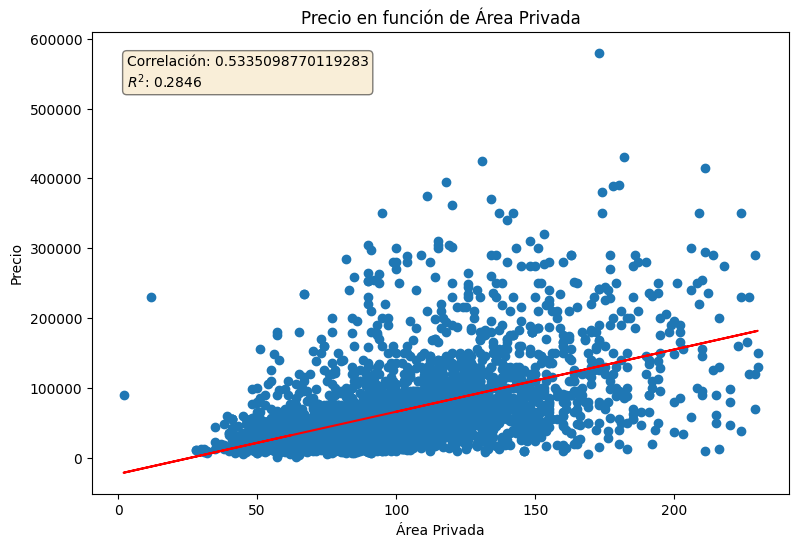

In [56]:
graph_numeric_relations(apartments, apartments_num_features)

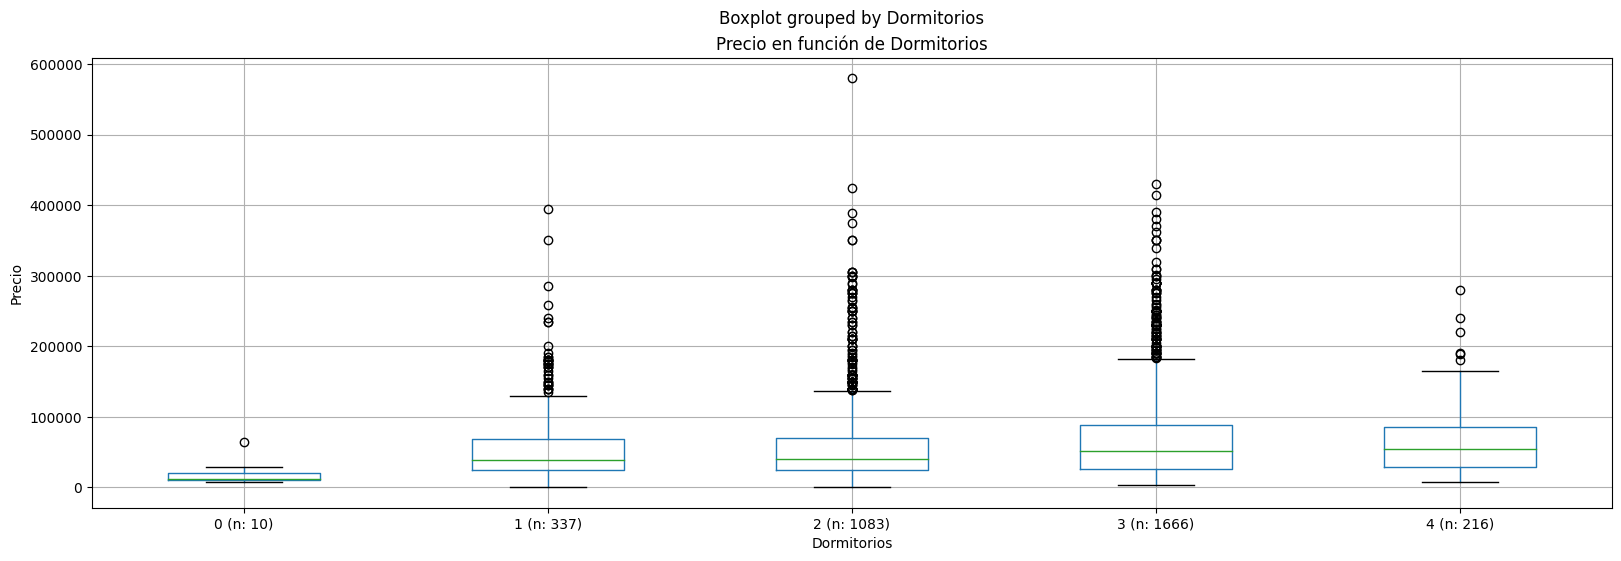

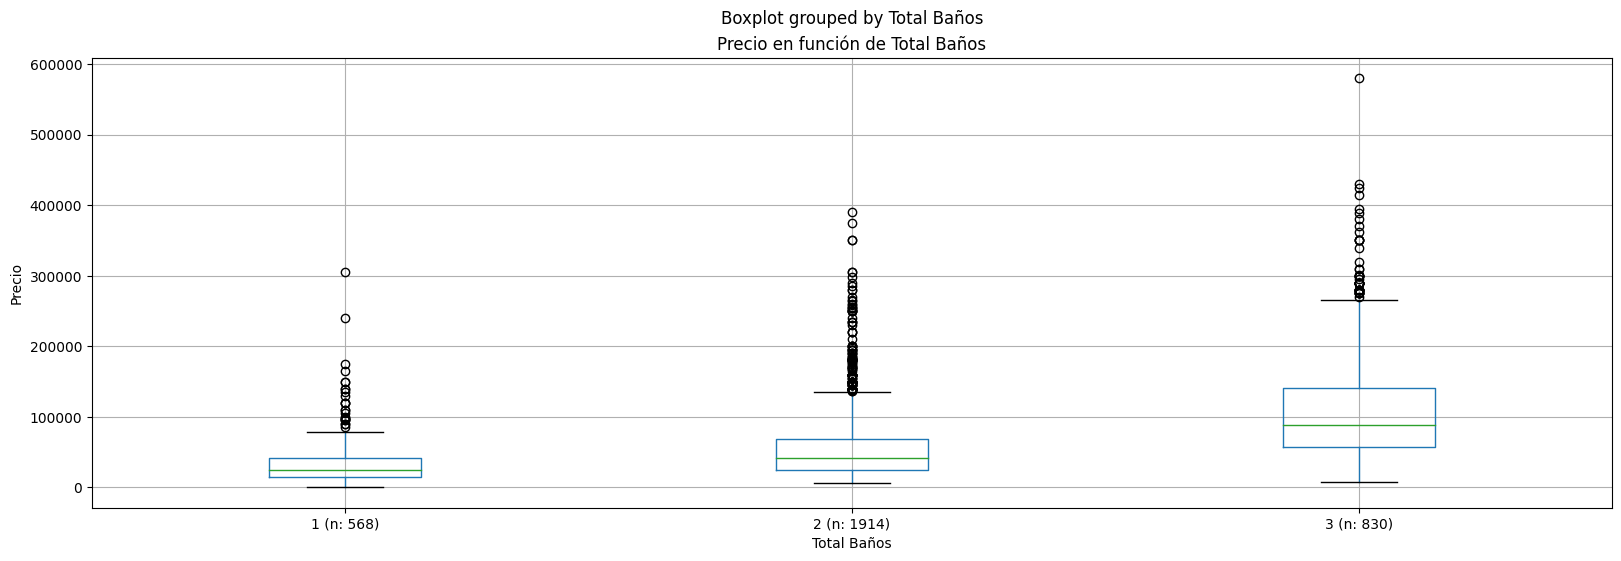

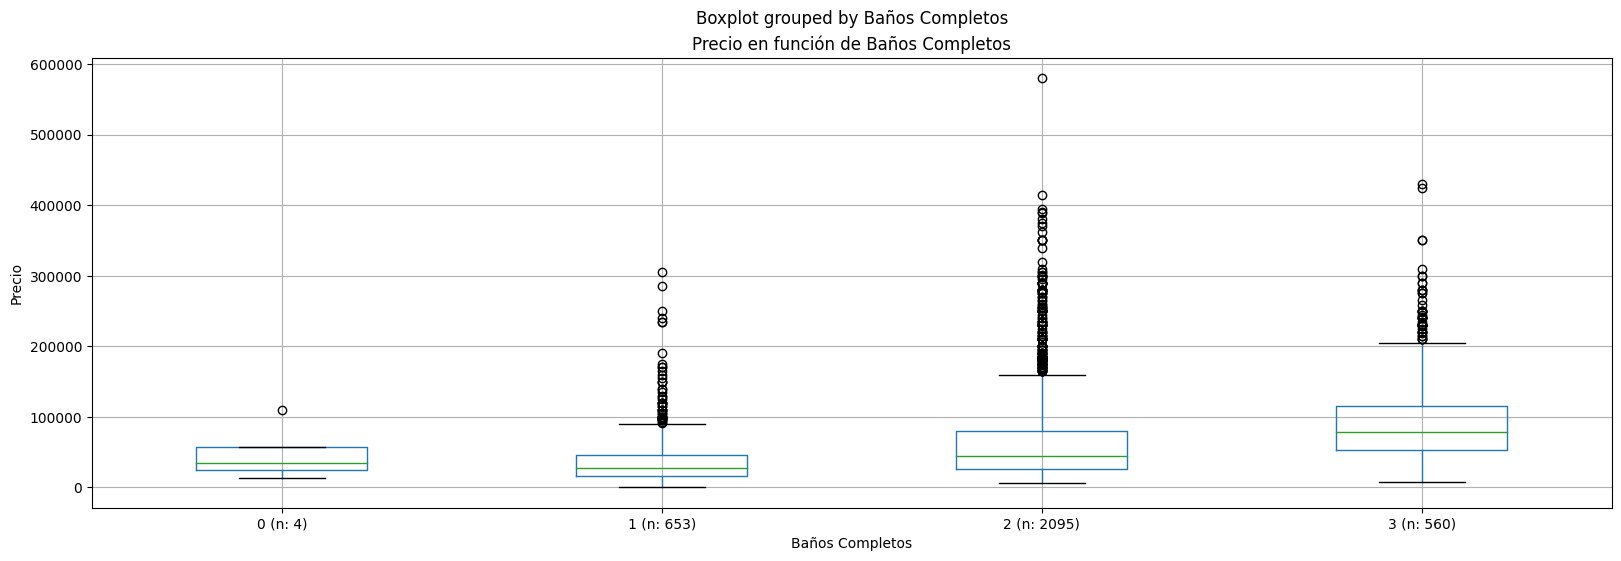

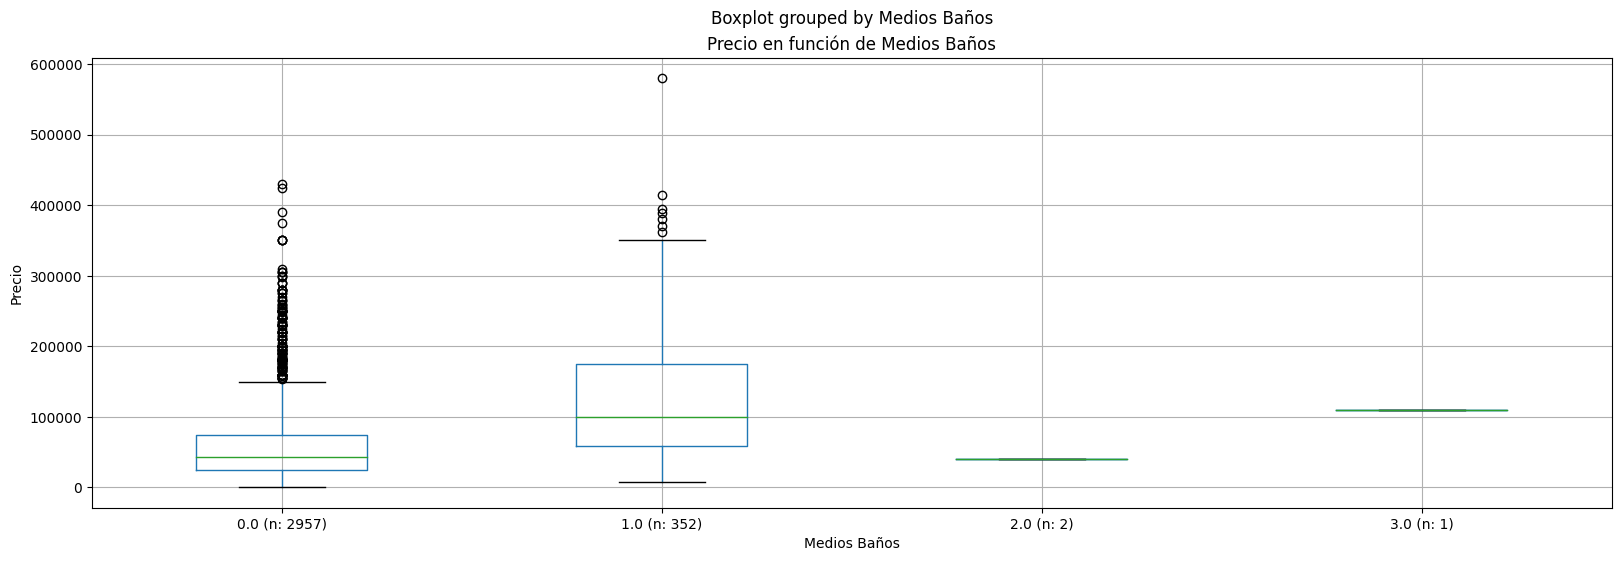

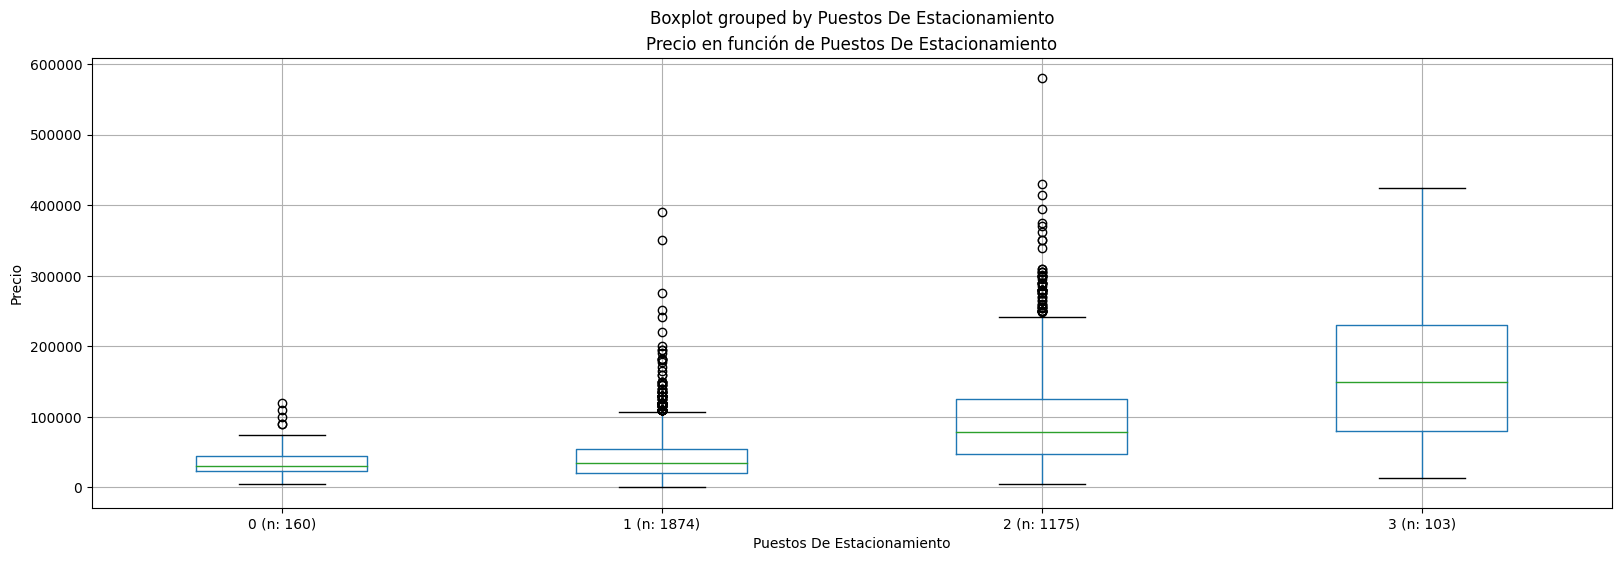

In [57]:
graph_categorical_relations(apartments, apartments_ord_features)

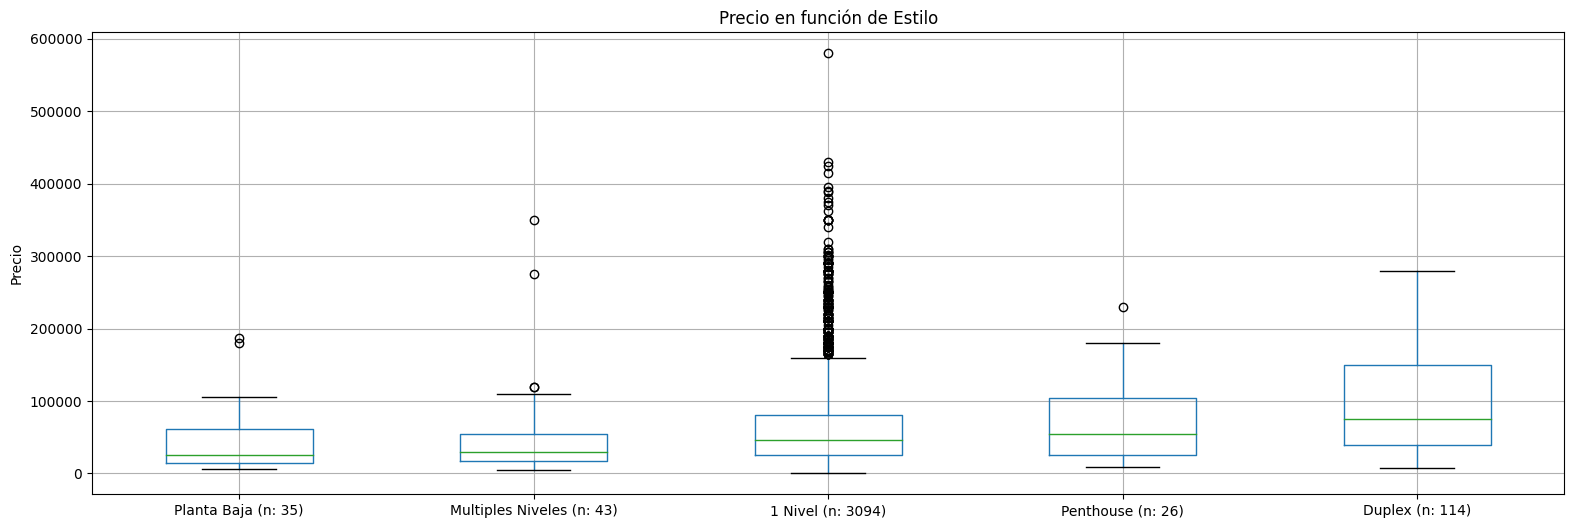

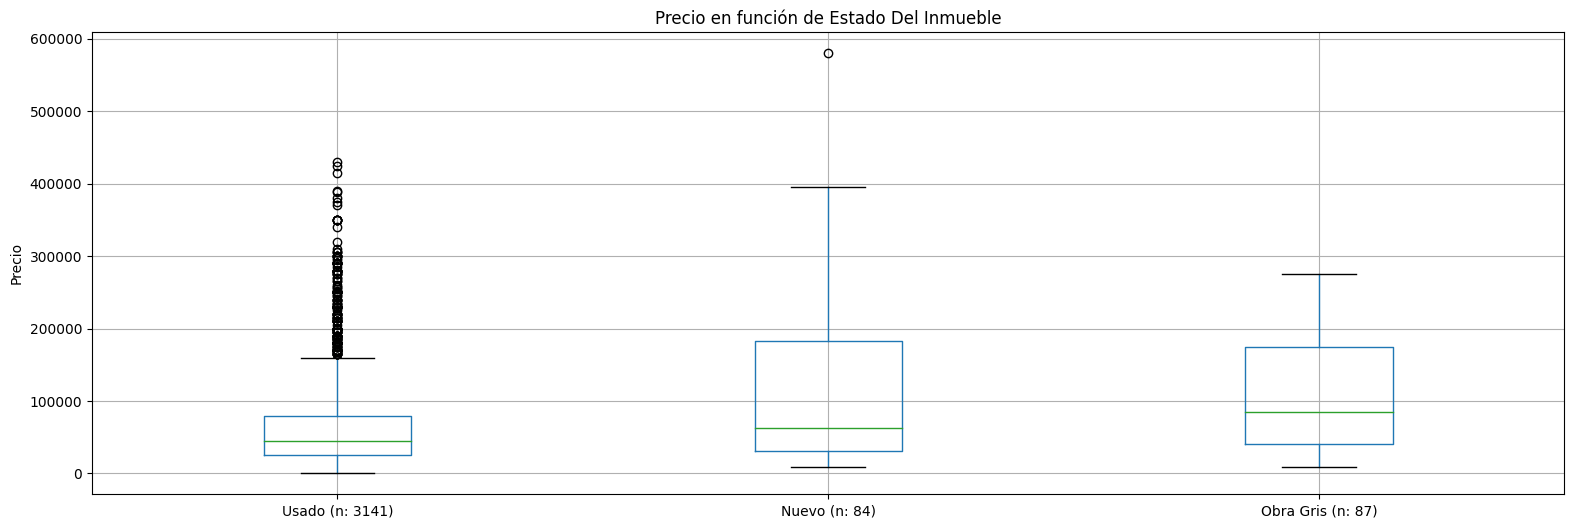

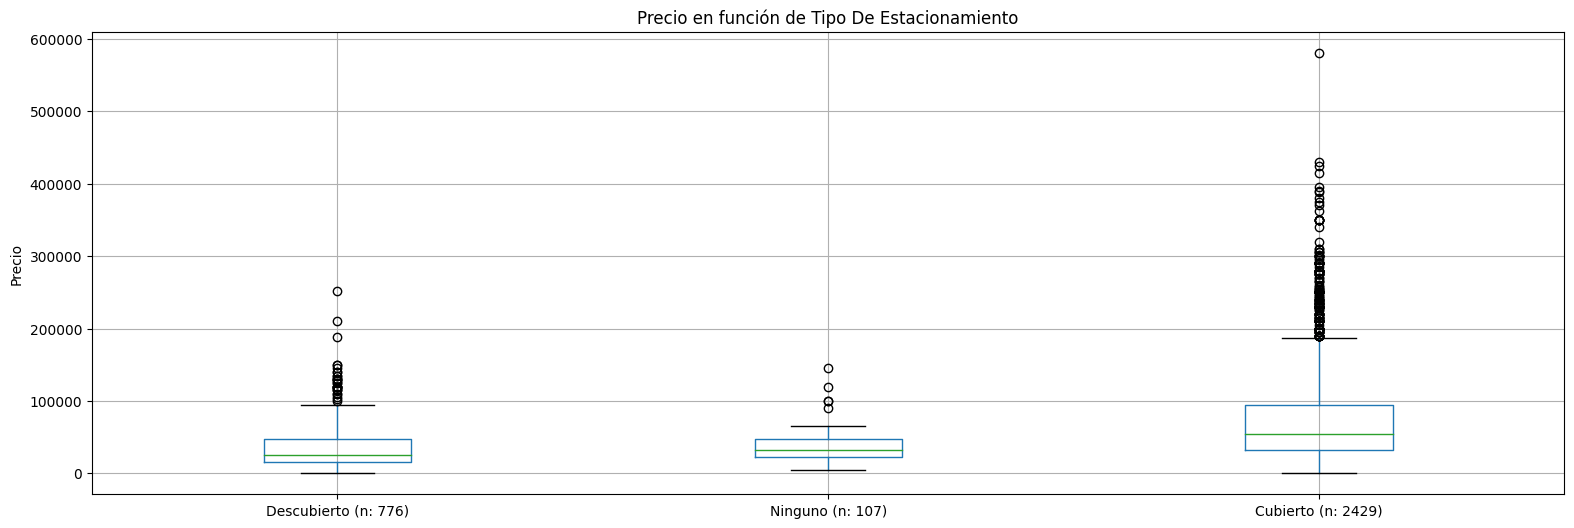

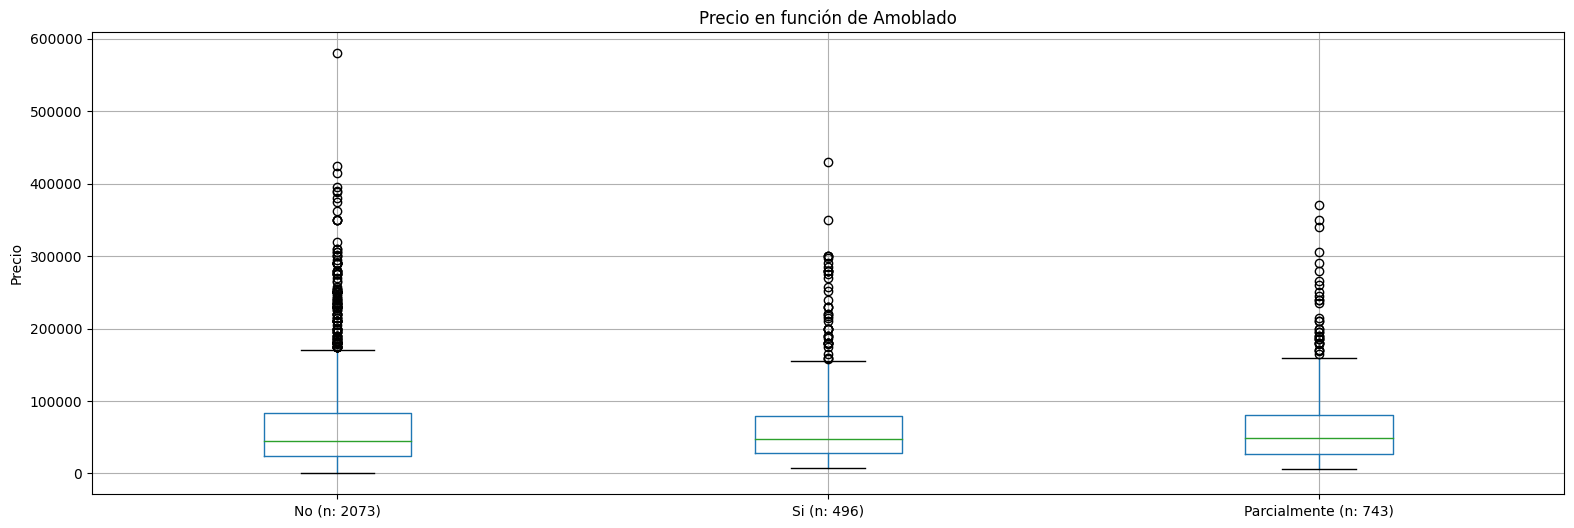

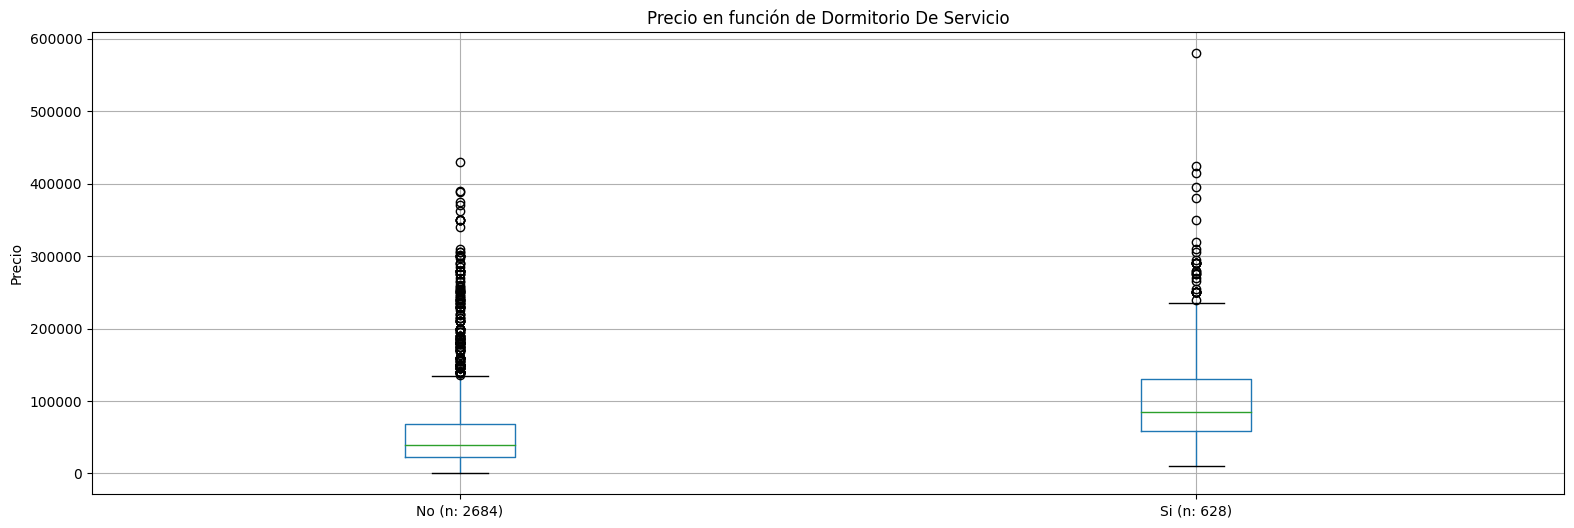

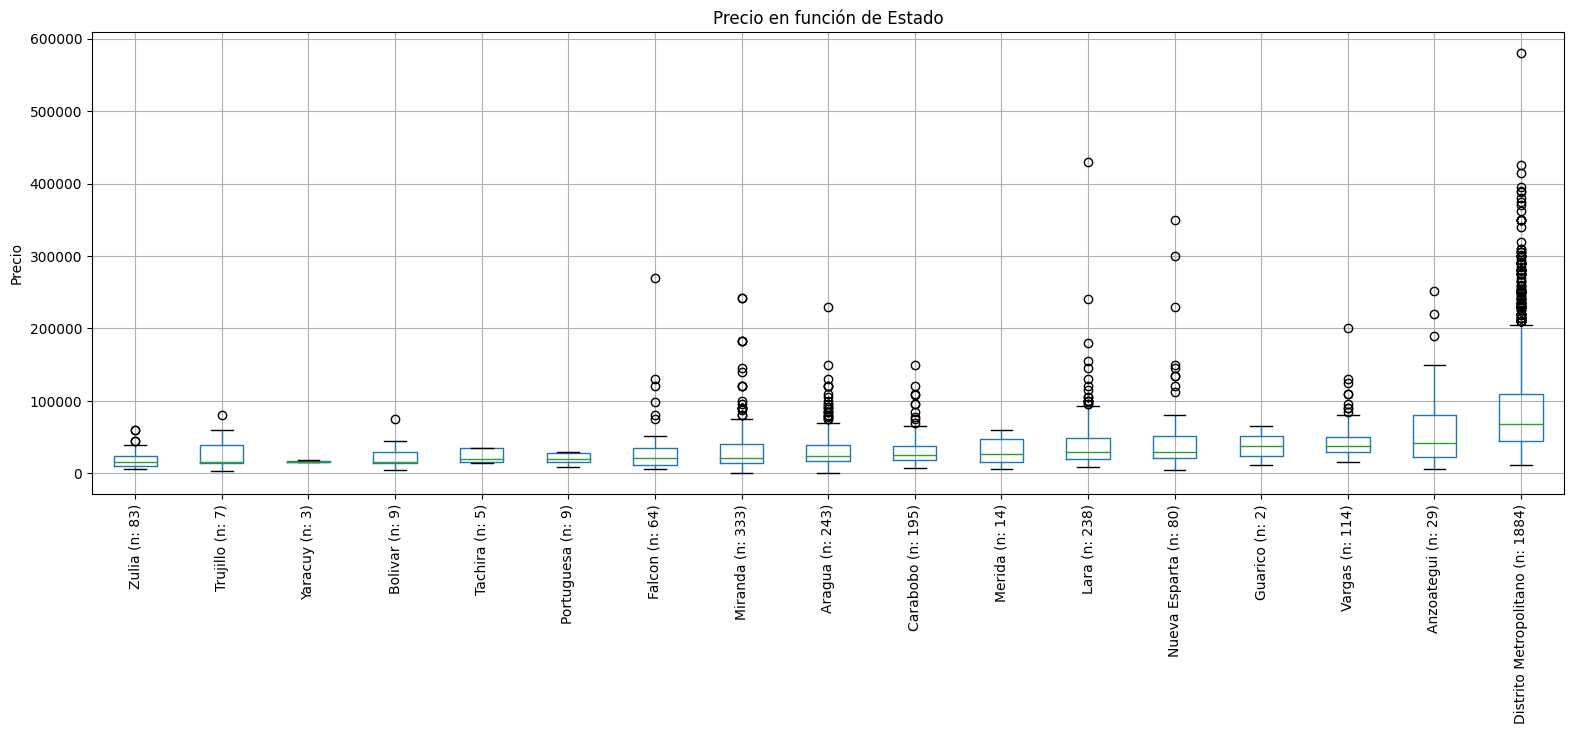

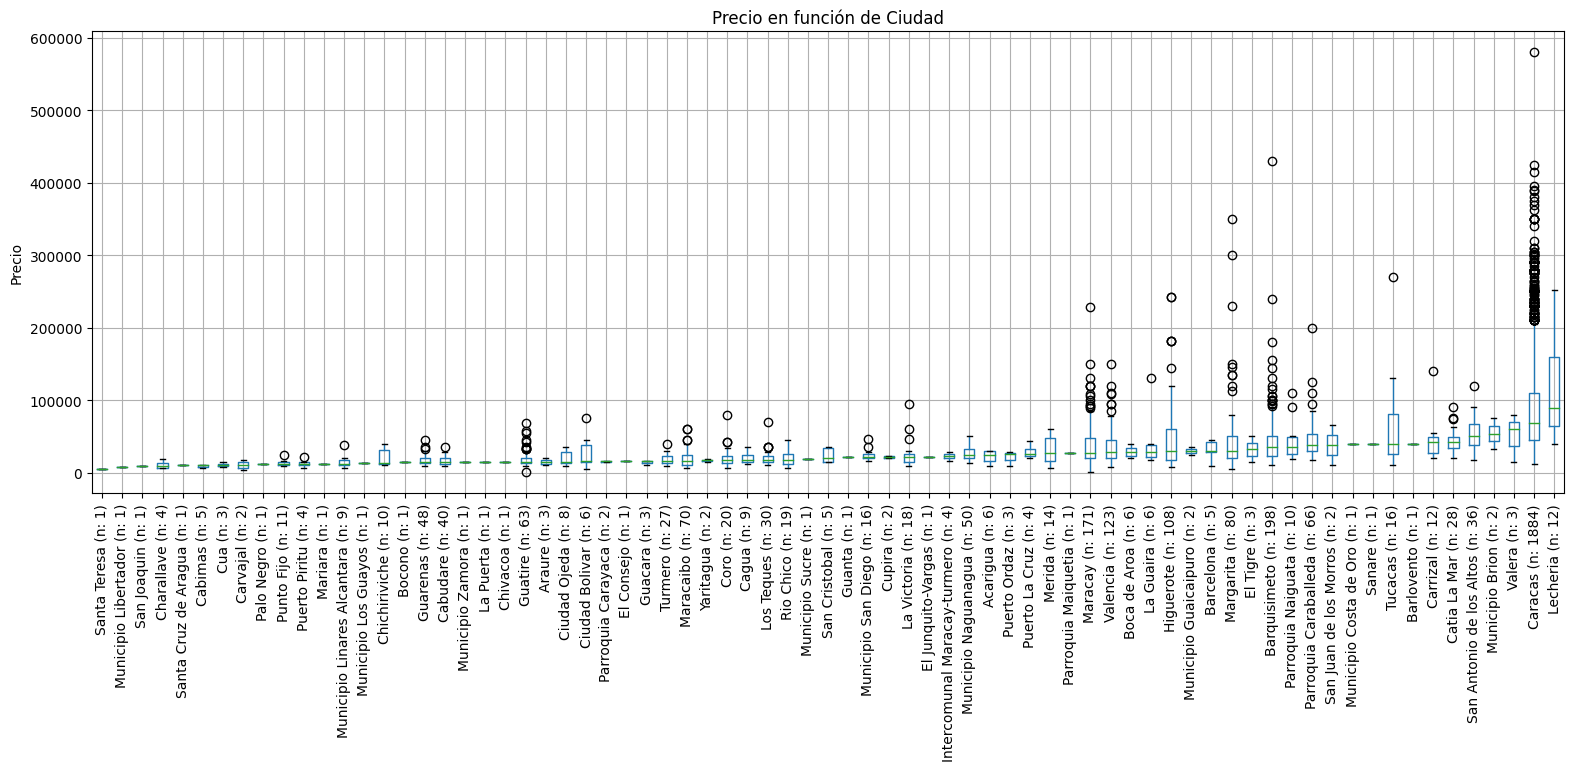

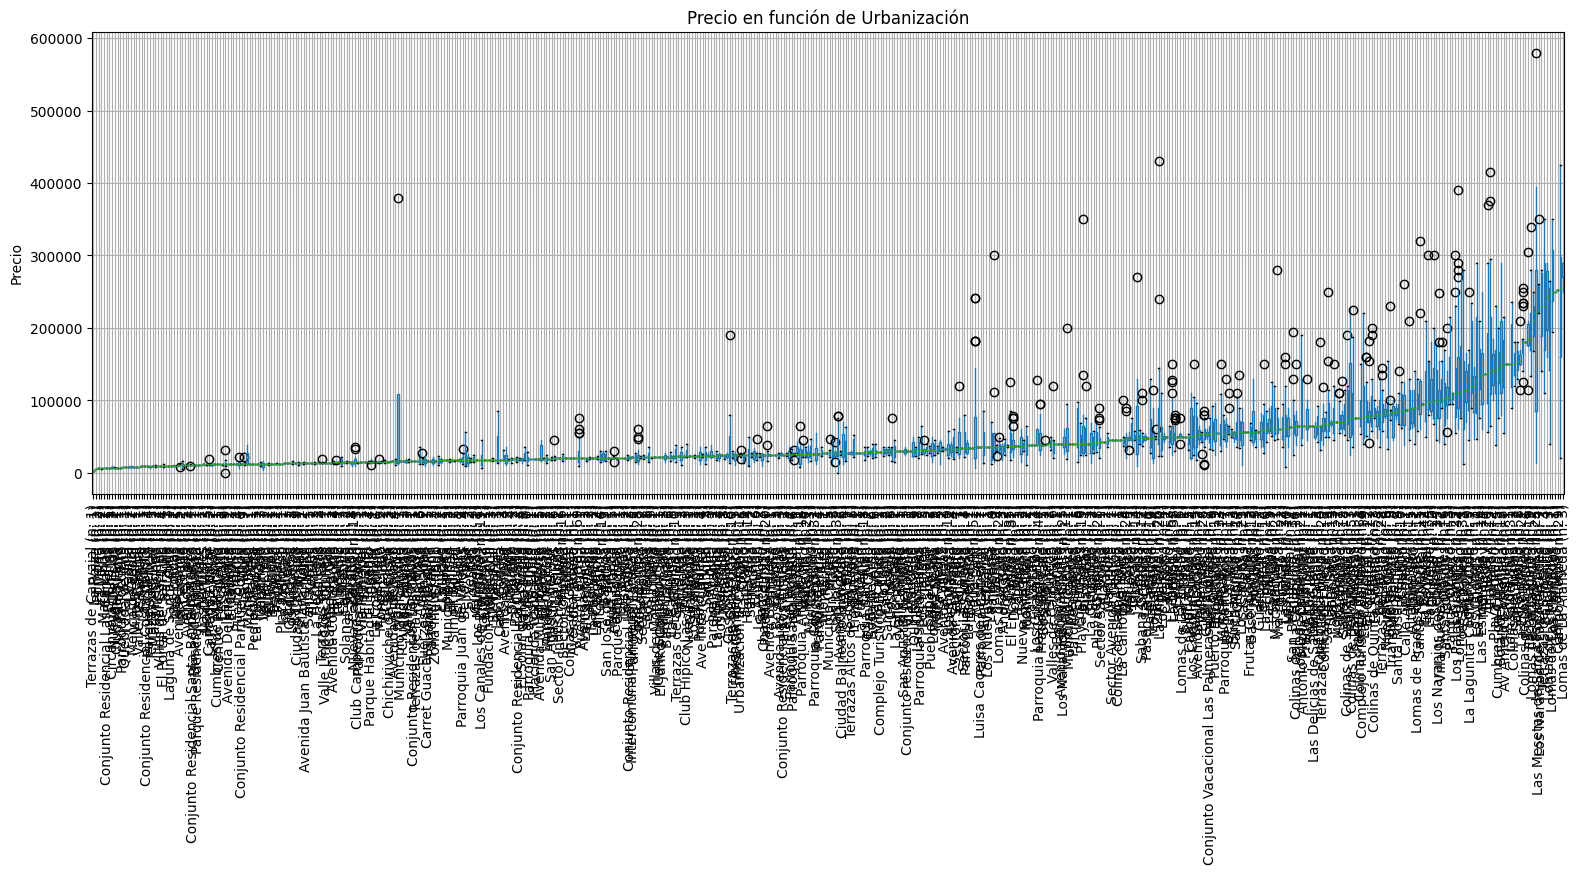

In [58]:
graph_categorical_relations(apartments, apartments_cat_fatures)

De los gráficos se observa una situación parecida a la de las casas. Aquí también se dejará de lado la columna de urbanizaciones.

In [59]:
apartments_cat_fatures = [cat for cat in apartments_cat_fatures if cat != 'Urbanización']

### Preprocesamiento

In [60]:
apartments.isnull().sum()

Precio                        0
Codígo RAH                    0
Tipo de Propiedad             0
Estilo                        0
Área Privada                  0
Estado Del Inmueble           0
Dormitorios                   0
Total Baños                   0
Baños Completos               0
Medios Baños                  0
Tipo De Estacionamiento       0
Puestos De Estacionamiento    0
Amoblado                      0
Dormitorio De Servicio        0
País                          0
Estado                        0
Ciudad                        0
Urbanización                  0
dtype: int64

En scrapeos anteriores habia discrepancias entre los puestos de estacionamiento y tipo de estacionamiento, asi que los voy a revisar.

In [61]:
apartments[(apartments['Puestos De Estacionamiento'] != 0) & (apartments['Tipo De Estacionamiento'] == "Ninguno")].head()

,Precio,Codígo RAH,Tipo de Propiedad,Estilo,Área Privada,Estado Del Inmueble,Dormitorios,Total Baños,Baños Completos,Medios Baños,Tipo De Estacionamiento,Puestos De Estacionamiento,Amoblado,Dormitorio De Servicio,País,Estado,Ciudad,Urbanización
869,48000,VE 23-24101,Apartamento,1 Nivel,89,Usado,3,2,2,0.0,Ninguno,1,No,No,Venezuela,Distrito Metropolitano,Caracas,El Bosque
1347,20000,VE 23-22441,Apartamento,1 Nivel,84,Usado,3,2,2,0.0,Ninguno,1,No,No,Venezuela,Lara,Barquisimeto,Parroquia Concepcion
1937,45000,VE 23-20478,Apartamento,1 Nivel,114,Usado,3,2,2,0.0,Ninguno,1,No,No,Venezuela,Merida,Merida,Avenida 2
2913,100000,VE 23-16579,Apartamento,1 Nivel,84,Usado,2,2,2,0.0,Ninguno,1,Si,No,Venezuela,Miranda,Higuerote,Agua Sal
2949,30000,VE 23-16436,Apartamento,1 Nivel,82,Usado,2,2,2,0.0,Ninguno,1,Parcialmente,No,Venezuela,Nueva Esparta,Margarita,Porlamar


In [62]:
houses[(houses['Puestos De Estacionamiento'] == 0) & (houses['Tipo De Estacionamiento'] != "Ninguno")].head()

,Área Privada,Terreno,Dormitorios,Total Baños,Baños Completos,Medios Baños,Puestos De Estacionamiento,Estilo,Estado Del Inmueble,Tipo De Estacionamiento,Amoblado,Calle,Dormitorio De Servicio,Ciudad,Estado,Precio,Precio predicho


In [63]:
mask_no_parking_spots = (houses['Puestos De Estacionamiento'] != 0) & (houses['Tipo De Estacionamiento'] == "Ninguno")
houses.loc[mask_no_parking_spots, 'Puestos De Estacionamiento'] = 0

In [64]:
# Pipeline preprocesador para departamentos
preprocessor = ColumnTransformer(transformers=
                                 [('num', numeric_transformer, apartments_num_features),('cat', categorical_transformer, apartments_cat_fatures)])

### Entrenamiento

In [65]:
print(apartments_num_features, apartments_ord_features, apartments_cat_fatures, sep='\n')

['Área Privada']
['Dormitorios', 'Total Baños', 'Baños Completos', 'Medios Baños', 'Puestos De Estacionamiento']
['Estilo', 'Estado Del Inmueble', 'Tipo De Estacionamiento', 'Amoblado', 'Dormitorio De Servicio', 'Estado', 'Ciudad']


In [67]:
# Me quedo solo con las columnas que voy a usar
apartments = apartments[apartments_num_features + apartments_ord_features + apartments_cat_fatures + ['Precio']]

In [69]:
# Separo en datasets de features y label
x_apartments, y_apartments = apartments.drop(labels=['Precio'], axis=1), apartments['Precio']
print('Features:',x_apartments[:3], '\nLabel:', y_apartments[:3].values, sep='\n')

Features:
   Área Privada  Dormitorios  Total Baños  Baños Completos  Medios Baños  \
1           100            3            2                2           0.0   
3           153            4            2                2           0.0   
4            45            1            1                1           0.0   

   Puestos De Estacionamiento   Estilo Estado Del Inmueble  \
1                           1  1 Nivel               Usado   
3                           2  1 Nivel               Usado   
4                           1  1 Nivel               Usado   

  Tipo De Estacionamiento      Amoblado Dormitorio De Servicio  \
1                Cubierto            No                     No   
3                Cubierto            No                     Si   
4             Descubierto  Parcialmente                     No   

                   Estado     Ciudad  
1  Distrito Metropolitano    Caracas  
3  Distrito Metropolitano    Caracas  
4                 Miranda  Rio Chico  

Label:
[75000 

In [71]:
# Separo en dataframes de entrenamiento y verificacion
x_apartments_train, x_apartments_test, y_apartments_train, y_apartments_test = train_test_split(x_apartments, y_apartments, test_size=0.2, random_state=69)
print(f"Training set: {x_apartments_train.shape[0]} filas\nTest set: {x_apartments_test.shape[0]} filas")

Training set: 2649 filas
Test set: 663 filas


In [72]:
preprocessor.fit(x_apartments_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Área Privada']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Estilo', 'Estado Del Inmueble',
                                  'Tipo De Estacionamiento', 'Amoblado',
                                  'Dormitorio De Servicio', 'Estado',
                                  'Ciudad'])])

In [73]:
x_apartments_train_ = preprocessor.transform(x_apartments_train)
x_apartments_test_ = preprocessor.transform(x_apartments_test)

In [74]:
def fit_model(ml_model, x_train, y_train, x_test, y_test):
    model = ml_model.fit(x_train, y_train)
    predictions = model.predict(x_test)

    mse = mean_squared_error(y_test, predictions)
    print("MSE:", mse)

    rmse = np.sqrt(mse)
    print("RMSE:", rmse)

    r2 = r2_score(y_test, predictions)
    print("R2:", r2)

    plt.scatter(y_test, predictions)
    plt.xlabel('Precio real')
    plt.ylabel('Precio predicho')
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.gca().ticklabel_format(style='plain')
    plt.show()

MSE: 2172577094.6954775
RMSE: 46610.91175567667
R2: 0.42935596324102476


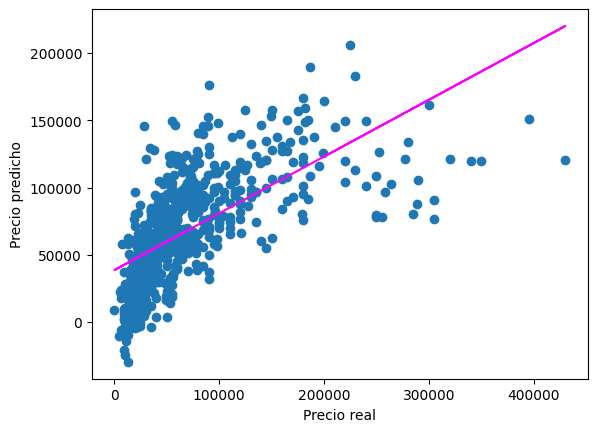

In [75]:
fit_model(LinearRegression(), x_apartments_train_, y_apartments_train, x_apartments_test_, y_apartments_test)

MSE: 2172986421.6610246
RMSE: 46615.3024409477
R2: 0.42924845037414217


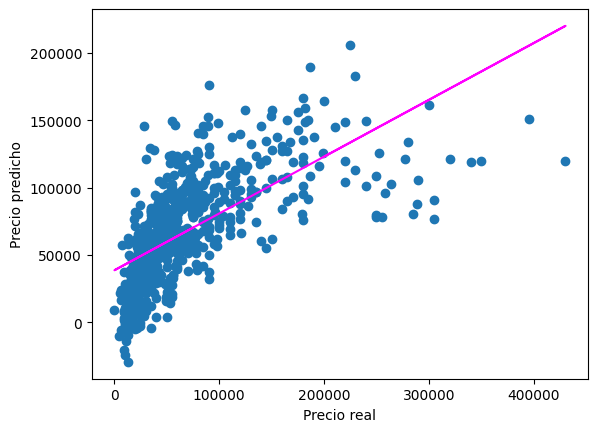

In [76]:
fit_model(Lasso(max_iter=18000), x_apartments_train_, y_apartments_train, x_apartments_test_, y_apartments_test)

MSE: 2384030278.9512434
RMSE: 48826.53253049251
R2: 0.37381616263102024


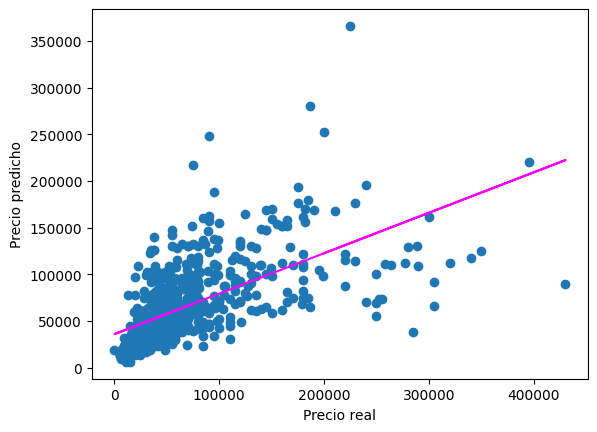

In [78]:
fit_model(RandomForestRegressor(), x_apartments_train_, y_apartments_train, x_apartments_test_, y_apartments_test)

MSE: 2127293817.7261791
RMSE: 46122.59552243541
R2: 0.4412499632424641


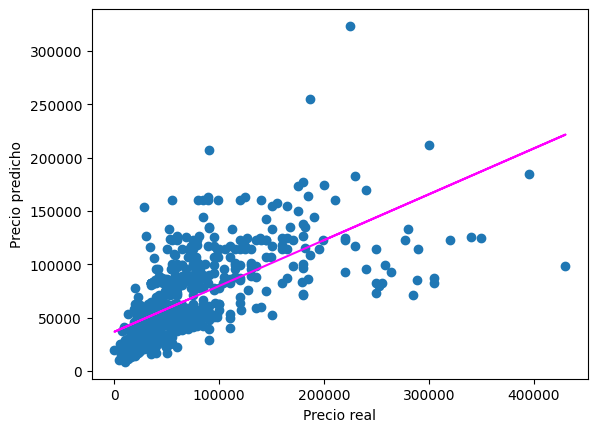

In [79]:
fit_model(GradientBoostingRegressor(), x_apartments_train_, y_apartments_train, x_apartments_test_, y_apartments_test)

Así como en las casas, voy a buscar los parametros optimos para el mejor modelo, que en este caso es Gradient Boosting.

In [80]:
params = {
    'n_estimators' : [10, 25, 50, 100, 200], 'learning_rate': [0.05, 0.1, 0.3, 0.5, 1],
    'min_samples_split': [2, 4, 8, 16], 'max_depth': [2, 4, 8, 16, 32, 50],
    'max_features': [None, 5, 10, 20, 50]}

score = make_scorer(r2_score)
gridsearch = GridSearchCV(GradientBoostingRegressor(), params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(x_apartments_train_, y_apartments_train)
print("Mejor combinacion de parametros:", gridsearch.best_params_, "\n")

model = gridsearch.best_estimator_
print(model, "\n")

predictions = model.predict(x_apartments_test_)
mse = mean_squared_error(y_apartments_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_apartments_test, predictions)
print("R2:", r2)

Mejor combinacion de parametros: {'learning_rate': 0.1, 'max_depth': 8, 'max_features': 5, 'min_samples_split': 16, 'n_estimators': 200} 

GradientBoostingRegressor(max_depth=8, max_features=5, min_samples_split=16,
                          n_estimators=200) 

MSE: 2023731696.6436749
RMSE: 44985.905533218676
R2: 0.46845134862673077


Esta optimización de parametros tomo mas de dos horas.

In [81]:
joblib.dump(model, './departamentos-modelo-ml.pkl')

['./departamentos-modelo-ml.pkl']

Así como para las casas, este modelo podría usarse para predecir (de manera holgada, debido a la poca precisión del mismo) el precio de los departamentos.

In [82]:
apartments['Precio predicho'] = np.round(model.predict(preprocessor.transform(apartments.drop(labels=['Precio'], axis=1))))

apartments.sort_values(['Precio', 'Precio predicho'], ascending=[True, False]).head()

,Área Privada,Dormitorios,Total Baños,Baños Completos,Medios Baños,Puestos De Estacionamiento,Estilo,Estado Del Inmueble,Tipo De Estacionamiento,Amoblado,Dormitorio De Servicio,Estado,Ciudad,Precio,Precio predicho
615,57,2,1,1,0.0,1,1 Nivel,Usado,Descubierto,No,No,Miranda,Guatire,220,9946.0
93,64,1,1,1,0.0,1,1 Nivel,Usado,Cubierto,No,No,Aragua,Maracay,280,19838.0
860,65,3,1,1,0.0,1,1 Nivel,Usado,Descubierto,No,No,Trujillo,Carvajal,3000,8926.0
3797,45,1,1,1,0.0,0,1 Nivel,Usado,Ninguno,No,No,Nueva Esparta,Margarita,4500,22994.0
966,75,3,1,1,0.0,2,Multiples Niveles,Usado,Cubierto,No,No,Bolivar,Ciudad Bolivar,5000,13798.0
